In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

# numpy setup
from numpy.random import default_rng
rng = default_rng()

# matplotlib setup
from matplotlib.animation import FuncAnimation
from IPython import display

%matplotlib inline 

plt.rc('font', size=15)
plt.rc('figure', figsize=(6, 4), dpi=150)

## Introduction

We will work with binary alignments instead of sequence today since we know what they are now
and they are easier to work with. No need to worry about different lengths or multiple alphabets.
Also, for read mapping, we assume the reads come from genome so we expect to be a perfect match or
one corrupted by errors of sequencing so we do not care about homology.

For simplicity we are going to treat the genome as a uniform, long, single chromosome and reads as coming from this chromosomes and are corrupted during the sequencing process with substitutions and/or artificial indels. In reality, the genome needs to pre-processed to get in this nice form and reads do not come from the reference genome but one similar enough to it, so some "errors" are not sequencing errors just reference differences.



## General Strategy

*Seed and extend* is canonical strategy for mapping reads to the genome. The same strategy that was employed by BLAST. It consists of 3 main steps:

1. Index: preprocess genome to facilitate search
2. Seed: combine query with index to reduce search space
3. Extend: local alignment

Why BLAST does not cut it for reads? SW is slow and in this case an "overkill".
We are not comparing homologous regions but corrupted copies of a region. We expect the 2 sequences to be almost identical, at least for small reads and the errors to be mostly substitutions. For longer reads, indels are more important. In either case, we know something about the error structure that vanilla SW does not exploit. Finally, we are want to map a huge number of reads ($\gt 10^7$) so we cannot afford multiples seeds for each.

There is a plethora of aligners:

![](https://www.ecseq.com/support/ngs/img/ngs_read_mappers_timeline.jpeg)
> source: https://www.ecseq.com

So going over every one of them is not an option. Instead we are going to focus on ideas that are employed by all. Alingers differ along 2 main dimensions.

1. How they construct their index.
2. How they perform local alignment.

![](figures/alser_fig2.webp)
> source: *Alser et al. Genome Biology (2021) 22:249. Figure 2*

We explore local alignment strategies in the previous lecture so we won't go over again here.
All aligners use some variation of Hamming or Levensthein distance to align reads locally once they have settled on a set of candidates.

Here we will focus on how they come up with the set of candidates to explore, ie how they construct their seeds & index. The 2 main technology for index construction are:

1. Hash Tables
2. Suffix Arrays (or trees)

Suffixed arrays are based on the Burrows-Wheeler Transform (BTW) in combination with Ferragina-Manzini (FM) index. A summary of their differences is show in the table below


| Feature        | Hashing | BWT-FM            |
|----------------|---------|-------------------|
| Implementation | Easy    | Hard              |
| Key matching   | Exact   | Exact and Inexact |
| Index Size     | Large   | Compressed        |
| Index time     | Fast    | Slow              |
| Query Time     | Fast    | Slow              |
| Seed Length    | Fixed   | Variable          |

> source: *Alser et al. Genome Biology (2021) 22:249. Table 2*

#### Main Sources

- [Ben Langmead Teaching Material](https://langmead-lab.org/teaching-materials/)
- [Short Read Mapping: An Algorithmic Tour](https://doi.org/10.1109/JPROC.2015.2455551)
- [Technology dictates algorithms: recent developments in read alignment](https://doi.org/10.1186/s13059-021-02443-7)

## Hash Tables

![](https://upload.wikimedia.org/wikipedia/commons/7/7d/Hash_table_3_1_1_0_1_0_0_SP.svg)
> source: Wikipedia [Hash Table](https://en.wikipedia.org/wiki/Hash_table)

Python `dict` are hash tables. They are data structure that facilitate the retrieval of data-values via keys. Keys are usually, and in our case, strings but they can be other "hashable" objects as well. They achieve this behavior by utilizing a *hash function* that maps these keys to integer that are then used as entries to an underlying array. Hash function are extremely fast regardless of the input and are not affected by the size of the underlying array so hash tables are optimized for data retrieval.

Named lists in `R` also provide the same functionality (associative array) but they are not hash tables, when you ask for a name `R` searches all the names to find a match it does not pass it through a hash function. 

For our purposes, we want to map DNA strings, and perhaps their reverse-complements, to offsets of the genome like we did for BLAST. Python `dict`s are more than enough for that, but just for fun of it and to (de)mystify the concept we are going to define our own hash table for $k$-mers.

As a hash function we are going to treat $k$-mers as numbers of fixed length. Each nucleotide we play the role of a numeral, so A=0, C=1, G=2, T=3. This defines a 4-ary numerical system. An example would be: $\text{CAT} = 1 \cdot 4^2 + 0 \cdot 4^1 + 3 \cdot 4^0 = 19$. We fix the length of the numbers because we don't want the strings like `T` and `AT` to be equal (if A=0)

In [3]:
class SimpleKmerHash:
    def __init__(self, k, canonical=True):
        """
        Create a simple Hash Table for DNA kmers.
        Arguments:
            k: the size of the k-mer. Must be fixed.
            canonical: whether kmers and their reverse complement should be treated as equivalent.
        """
        self.k = k
        # we use dict here for convenience. It's easy to avoid them if we want to.
        self._alphabet = {'A': 0, 'C': 1, 'G': 2, 'T': 3} 
        self._complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
        self._canonical = canonical
        self._array = [None] * 4**k  # hold space
    
    def kmer2int(self, kmer):
        """ 
        The hash function. Treats k-mer as a 4-ary number.
        The computation follows the notation. Not the fastest way to do it.
        """
        assert len(kmer) == self.k, \
            f'Wrong k-mer size. Expecte {self.k} got {len(kmer)} ({kmer})'
        if self._canonical:
            kmer = self.canonical_kmer(kmer)
        
        numerals = tuple(map(self._alphabet.get, kmer))
        # reverse numerals so that 1st correspond to the 0th power etc
        return sum(d * 4**i for i, d in enumerate(reversed(numerals)))
        
    def reverse_complement(self, kmer):
        return ''.join(self._complement[n] for n in reversed(kmer))
    
    def canonical_kmer(self, kmer):
        """ Returns the lexicographically smallest of the kmer and its reverse complement """
        rc = self.reverse_complement(kmer)
        return min(kmer, rc)
        
    def __getitem__(self, kmer):
        i = self.kmer2int(kmer)
        return self._array[i]
    
    def __setitem__(self, kmer, value):
        i = self.kmer2int(kmer)
        self._array[i] = value
    
    def __contains__(self, kmer):
        i = self.kmer2int(kmer)
        return self._array[i] is not None

In [4]:
def kmer2int(kmer, symbols={'A': 0, 'C': 1, 'G': 2, 'T': 3}):
    """Faster way to transform. Less multiplications"""
    y = 0
    base = len(symbols)
    for n in kmer:
        y *= base  # shift position
        y += symbols[n]  # add new least significant element
    return y
        

In [5]:
p, t = "CAT", "TTGTGTGCATGTTGTTTCATCATTTAGAGATACATTGCGCTGCATCATGGTAG"
#              01234567890123456789012345678901234567890123456789012
# Occurrences:        *         *  *           *         *  *

k = 3
def iter_words(text, k):
    L = len(text) - k + 1
    for i in range(L):
        yield text[i:i+k]

hashTable = SimpleKmerHash(k, canonical=False)
for i, kmer in enumerate(iter_words(t, k)):
    if kmer in hashTable:
        hashTable[kmer].append(i)
    else:
        hashTable[kmer] = [i]

hashTable[p]

[7, 17, 20, 32, 42, 45]

The art of read mapping with hash tables is to define the appropriate seeds that identify good candidate regions. There are several strategies for *seed template design* that try to balance sensitivity and specificity. We will explore a few here.

### k-mer seeds

The simplest approach is to use simple `k-mers` as we did for the BLAST alignment. We saw that the original BLAST used `k=13`. For Illumina level error rates (~0.1%), and assuming a random reference genome, we expect to find a seed matching perfectly by chance once every $10^{39}$ bases on average, which seems like an overkill, but the genome is not random.

![](https://kat.readthedocs.io/en/latest/_images/kmer_spectra1.png)
> A typical 31-mer spectrum of S.cerevisae S288C from [kat](https://kat.readthedocs.io)

We saw that the 2nd blast version uses 2 `11-mers` with 40 bp of each other. This technique is called *chaining* and it one of the standard tricks to trade-offs specificity for sensitivity. It's a form of spaced seeding essentially.

### Spaced Seeds

![](https://upload.wikimedia.org/wikipedia/commons/7/7a/Sequence_Alignment_Example.gif)
> Source: [wikipedia](https://en.wikipedia.org/wiki/Spaced_seed)

[PatternHunter](https://pubmed.ncbi.nlm.nih.gov/11934743/) popularized the use of *spaced seeds* (introduced [here](https://doi.org/10.1109/CVPR.1993.341106)) that increase the specificity.
Spaced seed look for non contiguous matches between reference and seed, ie the seed motif has gaps or ambiguous positions. 

Spaced seeds increase the specificity of the hits by:

1. Scanning a longer region of the genome for the name number of matches
   (and thus same sensitivity and essentially memory).
2. Decreasing the correlation of shifted version of themselves.

By scanning for a longer region, spaced seeds essentially shrink the search space and thus reduce the probability of random alignments. The sensitivity is only affected by the number of mismatches.

If we imagine an alignment of 2 sequences with a single mismatch then this mismatch will affect $k$ k-mers because we need $k$ shifts to "clear it". So contiguous k-mers are correlated essentially up to $k$ steps away, every shift decreasing the overlap by 1/k. By allowing gaps in the template, we reduce the overlap of the shifted k-mers whiles still achieving the same coverage of every base. Every base will be seen the same number of times but with a more diverse array of partners. 


We define a spaced seed template/mask $Q$ as a binary vector, with `1` in every position we expect a match and `0` for the "don't care" positions. We say that $Q$ has *span* `s = len(Q)` and weight `k = sum(Q)`, I use `k` to indicate that the space-seed equivalents of a standard k-mer are those with the same weight. Computation-wise, a spaced seed only affects the construction step of the hash table not its size or function as long as seeds with the same weight as before. 

In [6]:
k = 3  # k for kmer, weight for spaced-seeds
p, t = "TCT", "TTGTGTGCATGTTGTTTCATCATTTAGAGATACATTGCGCTGCATCATGGTAG"
#              01234567890123456789012345678901234567890123456789012
# Occurrences:                 1101101                     1101
p = 'TCT'
mask = '1101'  # regex = TC.T

def mask2offset(mask):
    return [i for i, m in enumerate(map(int, mask)) if m == 1]

def mask_kmer(kmer, mask):
    if type(mask) is str:
        mask = list(map(int, mask))
    assert len(kmer) == sum(mask)
    seed = ['.'] * len(mask)
    j = 0
    for i, m in enumerate(mask):
        if m == 1:
            seed[i] = kmer[j]
            j += 1
    seed = ''.join(seed)
    return seed

def iter_spaced_word(text, mask):
    offset = mask2offset(mask)
    L = len(text) - offset[-1]
    for i in range(L):
        yield ''.join(text[i+o] for o in offset)


# Hash table for spaced seeds
SpacedHash = SimpleKmerHash(k, canonical=False)
for i, kmer in enumerate(iter_spaced_word(t, mask)):
    if kmer in SpacedHash:
        SpacedHash[kmer].append(i)
    else:
        SpacedHash[kmer] = [i]

SpacedHash[p]

[16, 19, 44]

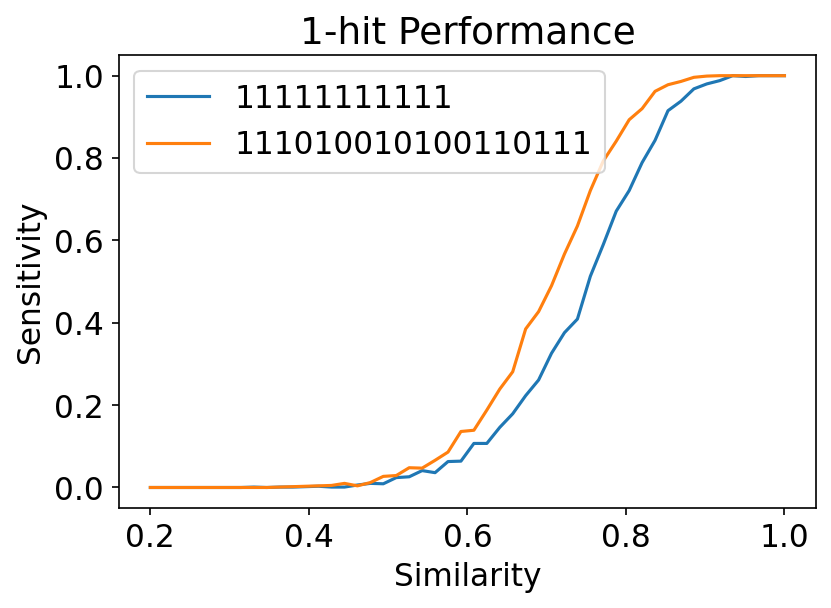

In [7]:
def count_hits(x, seed, k=None):
    """Compute the number of hits over an alignment for a given seed template"""
    if k is None:
        k = seed.sum()
    y = np.convolve(x, seed, mode='valid')
    return np.sum(y == k)

def iter_random_seq(N, L, p):
    """Generate N random alignments with probability of matching p."""
    for _ in range(N):
        x = rng.uniform(size=L) <= p
        yield x + 0


L = 64
patternhunter = '111010010100110111'  # PatternHunter optimal seed
ss = np.array([int(i) for i in patternhunter[::-1]])  # reverse for convolution
W = ss.sum()
s1 = np.ones(W, dtype=int)
P = np.linspace(0.2, 1)

N = 1000
sensitivity = np.zeros((len(P), 2))
for i, p in enumerate(P):
    y = np.array([[count_hits(x, s1, W), count_hits(x, ss, W)] for x in iter_random_seq(N, L, p)])
    sensitivity[i, :] = (y > 0).mean(0)

plt.plot(P, sensitivity[:, 0], label='1' * W)
plt.plot(P, sensitivity[:, 1], label=patternhunter)
plt.xlabel('Similarity')
plt.ylabel('Sensitivity')
plt.title('1-hit Performance')
plt.legend()
plt.show()

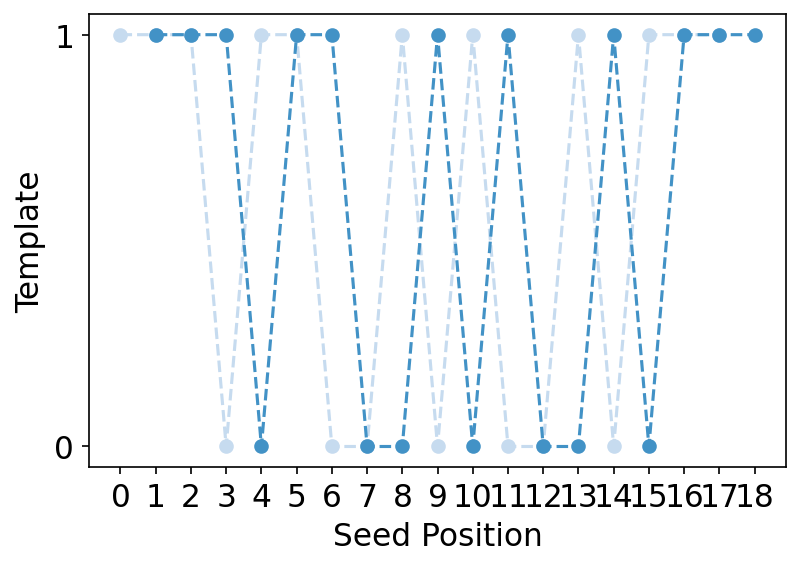

In [8]:
n = 2
blues = ("#C6DBEF", "#4292C6")
for i in range(n):
    plt.plot(np.arange(len(ss)) + i, ss, 'o--', color=blues[i], label=f'shift={i}')

plt.xlabel('Seed Position')
plt.xticks(np.arange(len(ss) + n - 1))
plt.ylabel('Template')
plt.yticks([0, 1])
plt.show()

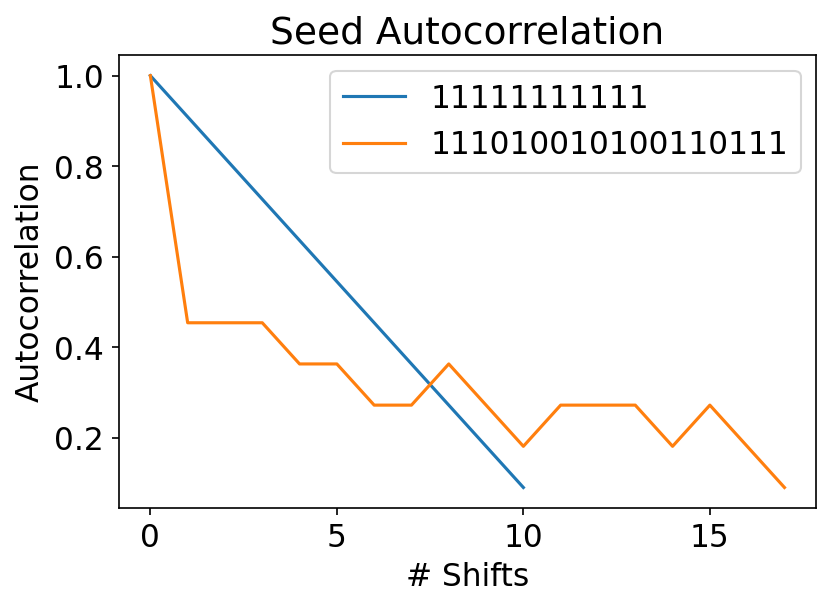

In [9]:
def autocorrelation(x):
    """ Not strictly autocorrelation but close enough for us. """
    res = np.correlate(x, x, mode = 'full')
    res = res[res.size//2:]
    return res/res[0]

plt.plot(autocorrelation(s1), label='1'*W)
plt.plot(autocorrelation(ss), label=patternhunter)
plt.xlabel('# Shifts')
plt.ylabel('Autocorrelation')
plt.title('Seed Autocorrelation')
plt.legend()
plt.show()

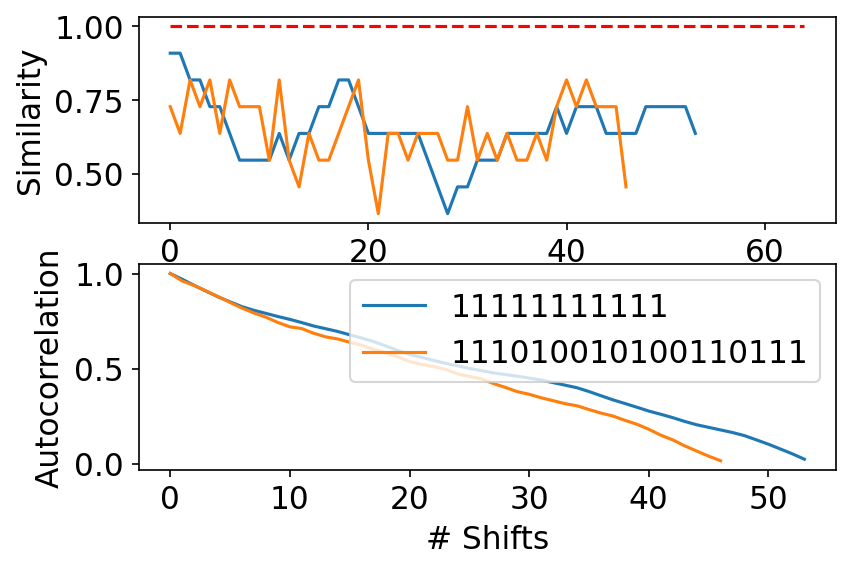

In [10]:
def autocorrelation(x):
    """ Not strictly autocorrelation but close enough for us. """
    res = np.correlate(x, x, mode = 'full')
    res = res[res.size//2:]
    return res/res[0]


p = .7
x = next(iter_random_seq(N, L, p))

fig, ax = plt.subplots(2, 1)
ax[0].plot(np.convolve(x, s1, mode='valid')/W)
ax[0].plot(np.convolve(x, ss, mode='valid')/W)
ax[0].plot([0, len(x)], [1., 1.], 'r--')
ax[0].set_xlabel('# Shifts')
ax[0].set_ylabel('Similarity')

y = np.convolve(x, s1, mode='valid')
ax[1].plot(autocorrelation(y), label='1'*W)

y = np.convolve(x, ss, mode='valid')
ax[1].plot(autocorrelation(y), label=patternhunter)
ax[1].set_ylabel('Autocorrelation')
ax[1].set_xlabel('# Shifts')

plt.legend()
plt.show()

### Multiseeds

A natural extension of the idea to boost the accuracy of indexing is to combine the information of multiple seeds. The idea is similar in spirit to that of spaced-seeds; by combing multiple seeds around a region we can avoid falling on an erroneous mismatch and thus have a perfect match that we can hash. Effectively we are trading a lot of specificity for little sensitivity. 
For a single seed of weight $k$:

1. Probability of finding a true match is: $(1-p_e)^k$, where $p_e$ is the probability of error.
2. The probability of finding a random match is: $1/4^k$ assuming all bases are equally likely.

So to boost sensitivity we want to decrease $k$ but to boost specificity we want to increase $k$.

If we use multiple *independent* seeds $S$ with $k' \gt k$ the new *false discovery rate* will be $\frac{|S|}{4^{k'}}$ so it will increase *linearly* by $|S|$ and decrease *exponentially* by $k'- k$. In the example given, 4 new seeds are balanced by increasing the $k$ by 1.

If we manage to combine these new seeds in smart way, we can control the penalty induced on sensitivity by the increasing $k$ and thus be better off overall. Some strategies to achieve that employed by NGS aligners are discussed below.

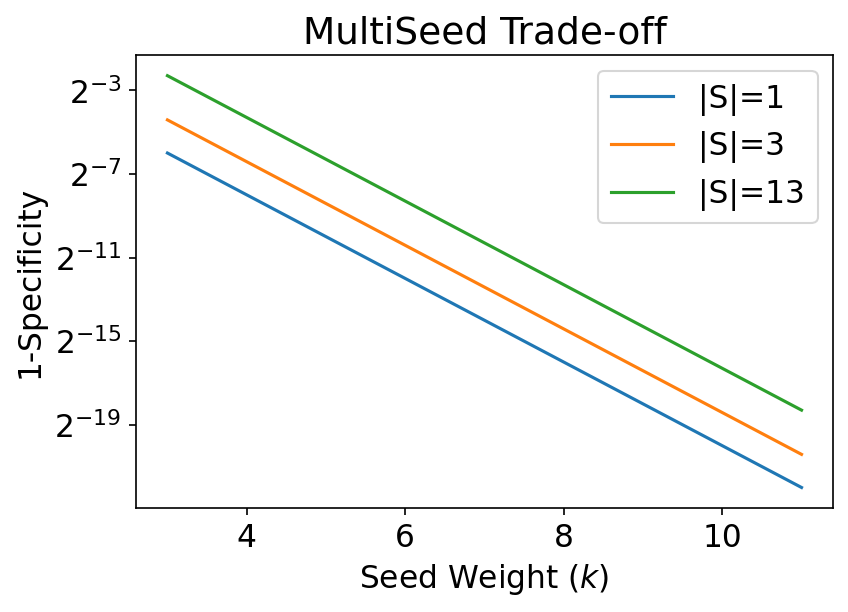

In [11]:
p = .25  # sequence similarity (0.25 = random)
k = np.arange(3, 13, 2)  # seed weight
Nseeds = [1, 3, 13]          # number of seeds


for N in Nseeds:
    FDR = N * p**k
    plt.plot(k, FDR, label=f'|S|={N}')
plt.ylabel('1-Specificity')
plt.xlabel('Seed Weight ($k$)')
plt.title('MultiSeed Trade-off')
plt.yscale('log', base=2)
plt.legend()
plt.show()

#### Disjunctive Seeds

Examples: [PatternHunter II](https://pubmed.ncbi.nlm.nih.gov/15359419/) and 
[BFAST](https://doi.org/10.1371/journal.pone.0007767) 

Disjunctive multi-seeds are combined with `OR` operation (disjunction), meaning that at least 1 of them needs to hit the true interval to match. The effect multiple seeds have on sensitivity is not easy to compute exactly as it depends to their design. So again we will settle for simulation.

We are going to use the top 4 seeds provided in the PatternHunter II paper.

In [12]:
# seeds
patternhunter2 = {11: ['111010010100110111', '111100110010100001011',  '110100001100010101111', '1110111010001111'], 
                  12: ['111011001011010111', '1111000100010011010111', '1100110100101000110111', '1110100011110010001101']}


N = 1000
Nseeds = min(map(len, patternhunter2.values()))
L = 64
P = np.linspace(0.25, 1)

def seed2mask(seed):
    return np.array([int(i) for i in seed[::-1]])

mask = {W: [seed2mask(x) for x in seed] for W, seed in patternhunter2.items()}
sensitivity = np.zeros((len(P), Nseeds, len(mask)))

for i, p in enumerate(P):
    for x in iter_random_seq(N, L, p):
        for k, W in enumerate(mask):
            y = np.array([count_hits(x, mask[W][j], W) > 0 for j in range(Nseeds)])
            sensitivity[i, :, k] += y.cumsum() > 0

sensitivity = sensitivity / N

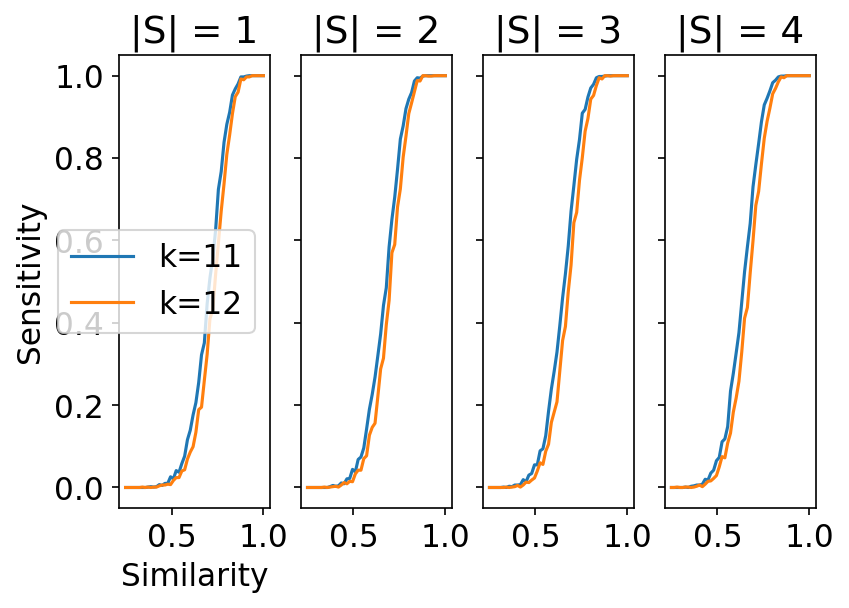

In [13]:
fig, ax = plt.subplots(1, Nseeds, sharex=True, sharey=True)


for j in range(Nseeds):
    ax[j].set_title(f'|S| = {j+1}')
    for k, W in enumerate(patternhunter2):
        ax[j].plot(P, sensitivity[:, j, k], label=f'k={W}', color=f'C{k}')
ax[0].set_xlabel('Similarity')
ax[0].set_ylabel('Sensitivity')
ax[0].legend()
plt.show()

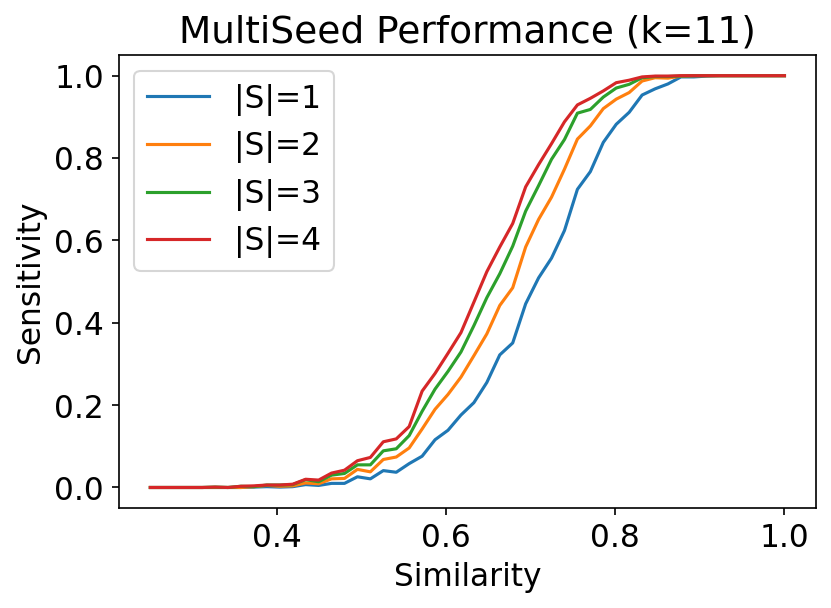

In [14]:
for j in range(Nseeds):
    plt.plot(P, sensitivity[:,j,0], label=f'|S|={j+1}')
plt.title('MultiSeed Performance (k=11)')
plt.xlabel('Similarity')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

#### Seed and Vote

[Subread](https://doi.org/10.1093/nar/gkt214) introduced *seed-and-vote*. The intuition is obvious I hope.

![](figures/subread_seed_vote_b.png)


#### Combinatoric

Some aligners aim to guarantee perfect matching under some assumptions about the distribution of errors. They make use of the pigeonhole principle or the q-gram lemma:

**Pigeonhole Principle**:

> if an alignment has $k$ mismatches and we split it in $s=k+1$ non-overlapping seeds then at 
least 1 seed is unaffected

![](figures/pigeonhole_principle.png)


MAQ (& Bowtie although it is not a hash-based aligner) seeds are design based on this principle. In particular, MAQ uses 6 spaced seeds templates to guarantee that any sequences with max 2 mismatches will be recovered. The seeds cover the fist 28bp (the most reliable part of the sequence usually) by splitting it into a 4 parts (each 7bp long) as shown below. This partition that no matter how the 2 errors are distributed, there will always be a 14-mer that is unaffected 

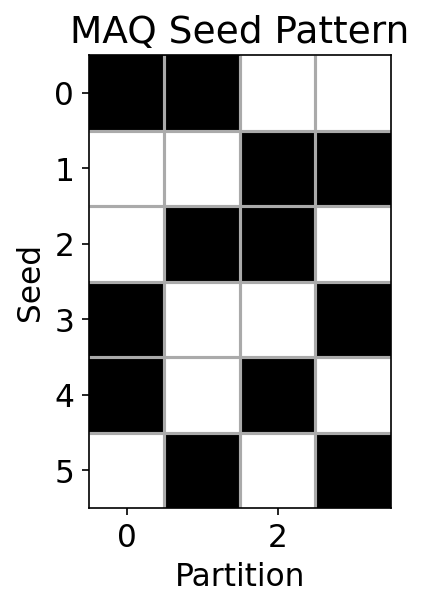

In [15]:
maq_seeds = np.array([[1,1,0,0], 
                      [0,0,1,1], 
                      [0,1,1,0], 
                      [1,0,0,1], 
                      [1,0,1,0], 
                      [0,1,0,1]])
plt.imshow(maq_seeds, cmap='gray_r')
plt.hlines(np.arange(5) + .5, -.5, 3.5, color='#AAAAAA')
plt.vlines(np.arange(3) + .5, -.5, 5.5, color='#AAAAAA')
plt.ylabel('Seed')
plt.xlabel('Partition')
plt.title('MAQ Seed Pattern')
plt.show()

**Generalized Pigeonhole Principle**:

> if an alignment has $k$ mismatches and we split it in $s \lt k+1$ non-overlapping seeds then there exist a seed with $m \le k/s$ mismatches.

*Proof*: If all the $k$ were split equally each seed would have $k/s$. Not all of them can have more than this because then total number or error would be greater than $s$ which is a contradiction. If one of them has more then it has to take it from somewhere so there ia *at least 1* seed with less.  


**q-gram lemma**:

> an alignment of length L with k errors have at least L + 1 - q(k+1) q-seed (ungapped) with no errors.

*Proof*: each error can only affect at most q seeds (until we shift over it) and there are $L + 1 -q$ seed to begin with

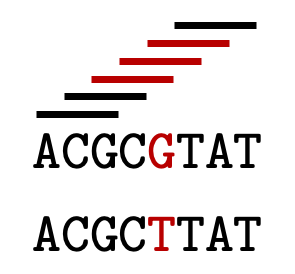

q-gram correspond to diagonals paths in the path-graph (that we saw in the pairwise-alignment section). Error then can have the following effect on the path:

- *substitution*: break the path into 2 sub-paths
- *deletion*: splits the path by shifting part of it to the right
- *insertion*: splits the path by shifting part of it down

So overall, a single error is cannot move a q-gram outside a parallelogram of size 2 centered around the original alignment. The same logic can be generalized to $k$ errors defining a parallelogram of size $k+1$. So when searching for seeds we only have to look inside this parallelogram. 

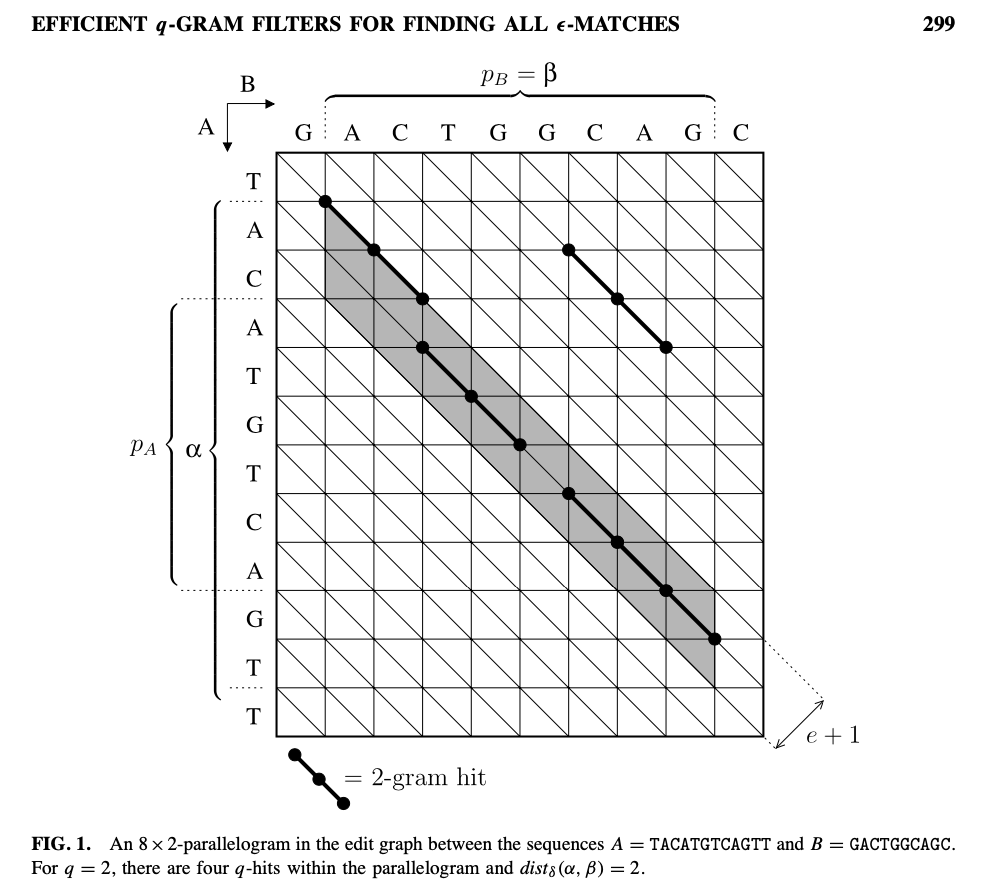

### Minimizers

Introduced by [Roberts et al, 2004](https://www.doi.org/10.1093/bioinformatics/bth408) you can select less seeds and achieve the same coverate 

Minimizers are a form of data compression. The motivating idea is instead of storing all the
k-mer of a sequence to store instead a *representative* set of k-mers and use their overlap
with any potential query to position it. Thus essentially they are a form of coding, where 
instead of the naive approach of 1-seed-to-1-position we try to come up with a scheme to encode
multiple positions with a few seeds.

Roberts proposed the scheme of $(w, k)$-minimizers, where for every $w$ consecutive $k$-mers, meaning shifted by 1, we pick as representative the smallest of them according to some fixed ordering (eg lexicographical). The "window" is then rolled along the sequence to pick up all the minimizers. An implementation with a visual example is shown below

In [16]:
def rank(x, key=None):
    # not really "rank" it does not handle draws
    rank = [0] * len(x)
    for i, o in enumerate(sorted(x, key=key)):
        rank[o] = i
    return rank

w, k = 4, 3
ref = 'GTCATGCACGTTCAC'
N = len(ref)
krank = rank(range(N-k+1), key=lambda i: ref[i:i+k])
minimizers = [i+np.argmin(krank[i:i+w]) for i in range(len(krank)-w+1)]
for m in sorted(list(set(minimizers))):
    print(ref[m:m+k])

ATG
ACG
CGT
CAC


In [17]:
fig, ax = plt.subplots()

kmers = []
for i, kr in enumerate(krank):
    kmers.append(ax.plot([i, i+k-1], [kr, kr], 'k-', linewidth=2)[0])
lines = [ax.plot([], [], 'r--')[0], ax.plot([], [], 'r--')[0]]

ax.set_xticks(np.arange(N), labels=list(ref))
ax.set_xlabel('Reference')
ax.set_ylabel('Kmer Rank')
ax.set_title(f'({w}-{k})-minimizers')
ax.set_ylim(-.5, N-k+.5)

wsize = w+k-1
def animate(i):
    wkmin = kmers[minimizers[i]]
    wkmin.set_color('red')
    lines[0].set_data([i, i], [-1, N-k+1])
    lines[1].set_data([wsize + i, wsize + i], [-1, N-k+1])
    return wkmin, lines[0], lines[1]
    
anim = FuncAnimation(fig, animate, frames=len(minimizers), interval=1000, blit=True) 
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

$w$ shifts of a $k$-mer defines a window of size $k+w-1$ ($k$ to begin and then $w-1$ shifts)
and since all these will be represented by a single $k$-mer:

- if 2 strings, eg query and subject of a search, have a common $k+w-1$ substring then they share a minimizer and thus its corresponding seeds. Consequently, we are guaranteed to find an alignment if a such a substring exists (lossless compression).
- 2 *consecutive* minimizers cannot be more than $w$bp apart (when each "dominates" its window)

In terms of compression, we select at best 1 $k$-mer out of every $w$ thus the minimum density possible is $1/w$. The set of minimizer present in a string define it's "minimizer fingerprint". Bins that share the same fingerprint are more likely to be aligned (and the rest can be discarded).

Minimizer are a special case of a *local scheme* where a $k$ is selected from a window of $w$ 
$k-mers$ based on a function $f$ that guarantees the above mentioned properties. The function $f$ is crucial for the density of coverage. Lexicographic order is not optimal due to the repeats of the genome (many `A` lead to many 
minimizers).

### Further Reading

- [Early review](https://doi.org/10.1093/bib/6.1.6)
- [Choosing the best heuristic for seeded alignment of DNA sequences](https://doi.org/10.1186/1471-2105-7-133)
- [Calibrating Seed-Based Heuristics to Map Short Reads with Sesame](https://doi.org/10.3389/fgene.2020.00572)
- [Superiority & Complexity of Spaced Seeds](https://doi.org/10.1007/978-3-642-27848-8_803-1)
- [Better Filtering with Gapped q-Grams](https://dl.acm.org/doi/10.5555/2370956.2370958)
- [All hits all the time: parameter-free calculation of spaced seed sensitivity](https://doi.org/10.1093/bioinformatics/btn643)
- [Multiseed Lossless Filtration](https://arxiv.org/abs/0901.3215v1)
- [Designing multiple simultaneous seeds for DNA similarity search](https://doi.org/10.1089/cmb.2005.12.847)
- [Asymptotically optimal minimizers schemes](https://doi.org/10.1093/bioinformatics/bty258) 


## Binary Search

Hash functions take a string and point you directly to its positions in an array. The cost for finding this index is "fixed", it does not depend on the size of the string and it does not matter if the string is in the reference. The size of the string and the presence of the string does affect the size of the resulting hash table though.

The naive/brute-force approach would be to search *sequentially* the reference for every string and record all its matches, and do that for any string given from scratch. That is clearly not optimal because for a string of length $m$ we need to make $m \times (n - m + 1)$ comparison where $n$ is the length of the reference and we need to multiply that by the number of reads we want to map which is in the 10s of millions.

There is an in between way to search arrays (faster than sequential but slower than hashing): *binary search*. To perform binary search the array needs to be sorted. If you know that the array is sorted you can compare the element you are looking for (strings in our case) to the middle element of the array and decide whether the query element is in the lower or the upper half of the array. You can then proceed to search the relevant half in similar fashion, effectively halving your problem in every step. Sorting an array is not free of course, but it is generally very fast and it only has to be done once (for static arrays) or even by someone else with bigger computer (like NCBI).

![](https://blog.penjee.com/wp-content/uploads/2015/04/binary-and-linear-search-animations.gif)
> from: https://blog.penjee.com/binary-vs-linear-search-animated-gifs/

In [18]:
class BruteForceIndex:
    def __init__(self, array):
        self._array = array
    
    def __getitem__(self, x):
        return [i for i, a in enumerate(self._array) if a == x]
    
    def __contains__(self, x):
        return x in self._array


class SmarterIndex:
    # https://github.com/python/cpython/blob/3.10/Lib/bisect.py
    def __init__(self, array):
        # python sort tuples by 0th element
        self._array = sorted((a, i) for i, a in enumerate(array))
    
    def _bisect_left(self, x, low=0, high=None):
        if high is None:
            high = len(self._array)
        while low < high:
            mid = (low + high) // 2
            if self._array[mid][0] < x:
                low = mid + 1
            else:
                high = mid
        return low
    
    def _bisect_right(self, x, low=0, high=None):
        if high is None:
            high = len(self._array)
        while low < high:
            mid = (low + high) // 2
            if x < self._array[mid][0]:
                high = mid
            else:
                low = mid + 1
        return low
    
    def __getitem__(self, x):
        array = self._array
        i = self._bisect_left(x)
        if i >= len(array) or array[i][0] != x:
            return []
        j = self._bisect_right(x, i)
        return [a[1] for a in array[i:j]]
    
    def __contains__(self, x):
        i = self._bisect_left(x)
        return i < len(self._array) and self._array[i][0] == x
    
    @property
    def array(self):
        """Returns the original array by sorting by (the original) index"""
        yield from (a[0] for a in sorted(self._array, key=lambda a: a[1]))

In [19]:
A = [1, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 37, 43, 47, 53, 59]  # example from gif with 37 repeated
rng.shuffle(A)
print(A)

[53, 43, 7, 3, 11, 37, 59, 29, 37, 5, 1, 19, 47, 13, 17, 31, 23]


In [20]:
BFI = BruteForceIndex(A)
print(BFI[37])
SI  = SmarterIndex(A)
print(SI[37])

[3, 7]
[3, 7]


In [21]:
%%timeit 
n = 10000
BFI = BruteForceIndex(rng.choice(1000, n))
for _ in range(100):
    a = rng.choice(1000, 1)[0]
    BFI[a]

97.5 ms ± 5.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
%%timeit 
n = 10000
SI = SmarterIndex(rng.choice(1000, n))
for _ in range(100):
    a = rng.choice(1000, 1)[0]
    SI[a]

13.7 ms ± 1.47 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
del SI, BFI

## Suffix Arrays

<!-- Structure and Function -->
The genome has *structure* that facilitates life, a "sorted genome" is *re-structured* to facilitate searching, so we see how the "same" data can be structured in different way to solve a problem. As we saw in the `SmartIndex` example, we can keep a copy of the original indexes (so double the memory cost effectively) if we want keep track of them. 

So now the question is, **what type of sorting is appropriate for mapping reads?**

<!-- Sort k-mers -->
If we want to reproduce the function of a hash table (but be worse at it for some reason) then the answer is *all the k-mers* of the genome. That is definetely and option as *k-mers* can be ordered (and thus compared) [lexicographically](https://en.wikipedia.org/wiki/Lexicographic_order) (which basically means alphabetically in this case). Sorting all the k-mers involves going through every position of the genome and comparing the `k` bases starting there with those of all the other positions. As it was the case for hash table we will only consider *exact matches* for now.

<!-- Lexicographic Order -->
To compare 2 words lexicographically we have to left-align them and then proceed to compare them letter by letter until we find a difference in which case we declare the word with the "smallest" letter in the alphabet to be the smallest of the 2. To deal with the problem of running out of letters before we decide which one is smaller (eg `align` and `alignment`) we say that every word ends with a end word character `$` (which is not displayed) that is alphabetically the smallest.

```
align$
|||||^
alignment$
```

<!-- k-mers as suffixes -->
We can think of these k-mers than as the *k-suffixes* since they start at position `i` and the move `k` positions towards the *end* of the genome. Limiting ourselves to k-suffixes is fine but since sorting is generally cheap, we can just go ahead and order the *all the suffixes* essentially creating an order **suffix array**.

Since we are going to compare our seeds character by character anyway to decide their position in the array (no magic hash functions), suffix arrays are implementing a variable-length index. If we limit ourselves to k-suffixes we just limit the index to reads up to $k$-bp long. If the read is longer than $k$-bp then we have to compare the rest of it sequentially for all the suffixes in our bisect range. For the examples presented here, we are going to focus on full suffixes to avoid the complications.

In [25]:
def build_suffix_array(text, k=None):
    if text[-1] != '$':
        text += '$'
    n = len(text)
    if k is None:
        suffixes = iter((text[i:], i) for i in range(n))
    else:
        suffixes = iter((text[i:min(n, i+k)], i) for i in range(n))
    return [s[1] for s in sorted(suffixes)]

sa = build_suffix_array('abaaba')
sa

[6, 5, 2, 3, 0, 4, 1]

In [26]:
class SAIndex:
    def __init__(self, text):
        self.text = text
        self.sa = build_suffix_array(text)
        self.n = len(self.sa)
    
    def _bisect_left(self, p, low=0, high=None):
        if high is None:
            high = self.n
        while low < high:
            mid = (low + high) // 2
            i = self.sa[mid]
            if self.text[i:i+len(p)] < p:
                low = mid + 1
            else:
                high = mid
        return low
    
    def _bisect_right(self, p, low=0, high=None):
        if high is None:
            high = self.n-1
        while low < high:
            mid = (low + high) // 2
            i = self.sa[mid]
            if p < self.text[i:i+len(p)]:
                high = mid
            else:
                low = mid + 1
        return low
    
    def match(self, p, i):
        if i < 0 or i > len(self.text) - len(p):
            return False
        return self.text[i:i+len(p)] == p
    
    def __getitem__(self, p):
        i = self._bisect_left(p)
        if i >= self.n or not self.match(p, self.sa[i]):
            return []
        j = self._bisect_right(p, i)
        return self.sa[i:j]  # sort if you want them in order of appearance
    
    def __contains__(self, p):
        i = self._bisect_left(p)
        return self.match(p, self.sa[i])

In [27]:
text = 'abaabab'
#       0123456
# ab @  *  * *

SAI = SAIndex(text)
SAI['ab']

[5, 0, 3]

### Burrows-Wheeler Transform

So far, we have seen how k-mers can be used as seeds and their trade-offs, and we also show how we can "extend" them essentially to make variable-sized seeds. Unfortunately, this is where the intuitive ideas stop... The Burrows-Wheeler Transform (BWT) is harder to demystify.

The BWT is a way to combine suffix-arrays and text into the same data-structure. As we saw in the `SAIndex` class, we had to keep the `text` and the `sa` separate and do some index-swapping (`i` and `j` referred to `sa` but `sa[i]` and `sa[j]` referred to the `text` and there was no way to go from `sa[k]` back to `text`). BWT is going to "sort" the text itself in order to produce its own suffix array *and* the original text. 

Pictorially the BWT is constructed as follows:

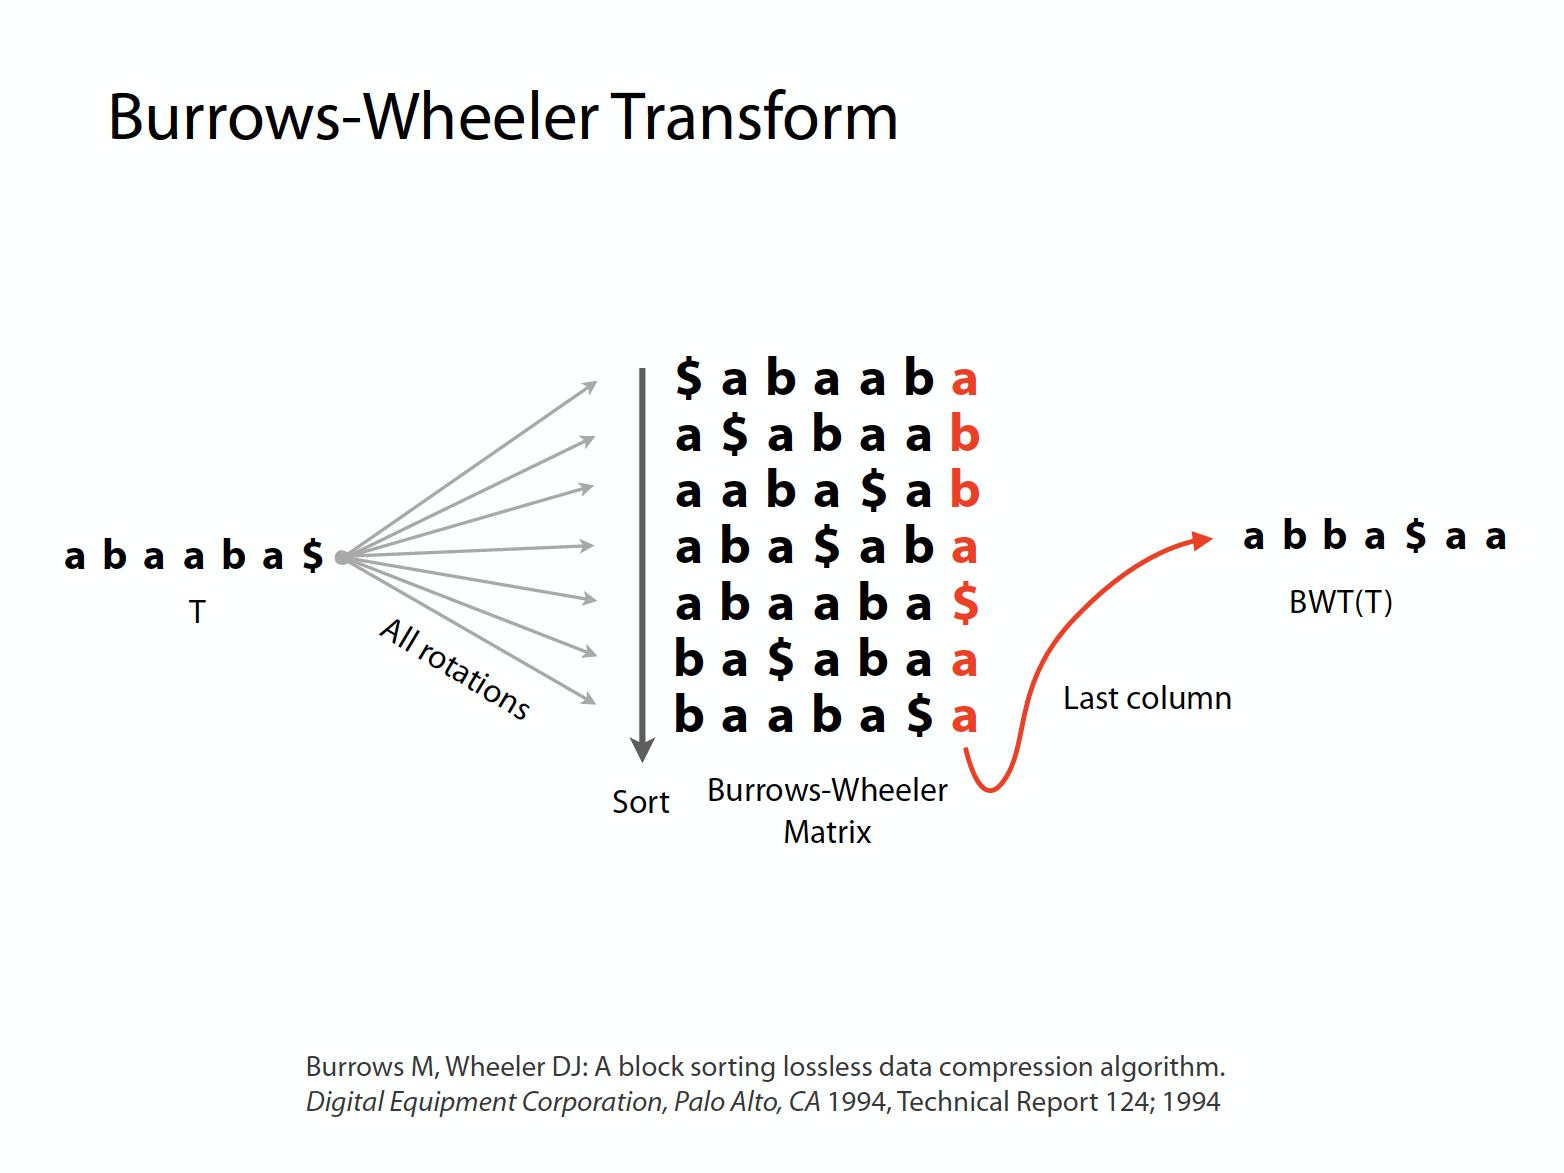
> source: http://www.cs.jhu.edu/~langmea/resources/lecture_notes/220_bwt_intro_boost_pub.pdf


The steps are as follow:

1. Add the end-of-string character `$` to the text
2. Produce all the rotations of the text. 
3. Sort them alphabetically to produce the Burrows-Wheeler Matrix (BWM)
4. Take the last column of the matrix

In [28]:
def rotations(text):
    """ 
    Return list of rotations of input string text 
    """
    for i in range(len(text)):
        yield text[i:] + text[:i]

def BWM(text):
    """ 
    Burrows–Wheeler Matrix of text. 
    Return lexicographically sorted iter of rotations 
    """
    if text[-1] != '$':
        text += '$'
    yield from sorted(rotations(text))


def BWT(T):
    """ 
    Burrows–Wheeler Transform
    Given T, returns BWT(T) by constructing BWM and taking the last column.
    """
    return ''.join(x[-1] for x in BWM(T))

text = 'abaaba$'
BWT(text)

'abba$aa'

The addition of `$` is very important as it renders all the rotations unique (it breaks symmetries) and also "indexes" them (position of `$` is equal to the number of shifts performed).

In [29]:
print('With $')
print('-----------')
text = 'abaaba$'
for i, t in enumerate(rotations(text)):
    print(f'{i}: {t}')
    
print('\nWithout $')
print('-----------')
text = 'abaaba'
for i, t in enumerate(rotations(text)):
    print(f'{i}: \033[{31+(i%3)}m{t}\033[0;0m')

With $
-----------
0: abaaba$
1: baaba$a
2: aaba$ab
3: aba$aba
4: ba$abaa
5: a$abaab
6: $abaaba

Without $
-----------
0: abaaba
1: baabaa
2: aabaab
3: abaaba
4: baabaa
5: aabaab


By rotating the string, we are essentially bringing all of its suffixes to the front so later when we sort, the sorted matrix is connected to the suffix-array we constructed. The "magic" comes from the fact that we can discard (more or less, more "more" than "less") the matrix and do not lose this functionality.

Below we show how we can construct the BWT from the suffix array. Every rotation shift (cyclically) the string to the right so the order of the rotation is associated with the character it brings to the end (`text[i:] + text[:i]`) so if we reorder the text by the order specified by the SA we will have the BWT, ie `BWT(T) := T[SA-1]`.

In [34]:
def pretty_print_bwm(text):
    print(f'Burrows-Wheeler Matrix of: {text}\n')
    sa = build_suffix_array(text)
    for i, t in enumerate(BWM(text)):
        print(f'{sa[i]:>2}:  {t[:-1]}|{t[-1]}')


pretty_print_bwm(text)

Burrows-Wheeler Matrix of: abaaba

 6:  $abaab|a
 5:  a$abaa|b
 2:  aaba$a|b
 3:  aba$ab|a
 0:  abaaba|$
 4:  ba$aba|a
 1:  baaba$|a


In [30]:
def BWT(t, sa=None):
    """ Given text t and suffix-array, returns BWT(text)."""
    if t[-1] != '$':
        t += '$'
    if sa is None:
        sa = build_suffix_array(text)
    return ''.join(t[i-1] for i in sa)

BWT(text)

'abba$aa'

As a bonus, because the BWT is sorted by suffix (or *right-content*) it tends produce runs of the same character that facilitate compression. In fact BWT was initially developed for compression and is utilized for this by [bzip2](https://en.wikipedia.org/wiki/Bzip2). That is why it is a bit hard to come up with a good intuition for read mapping.

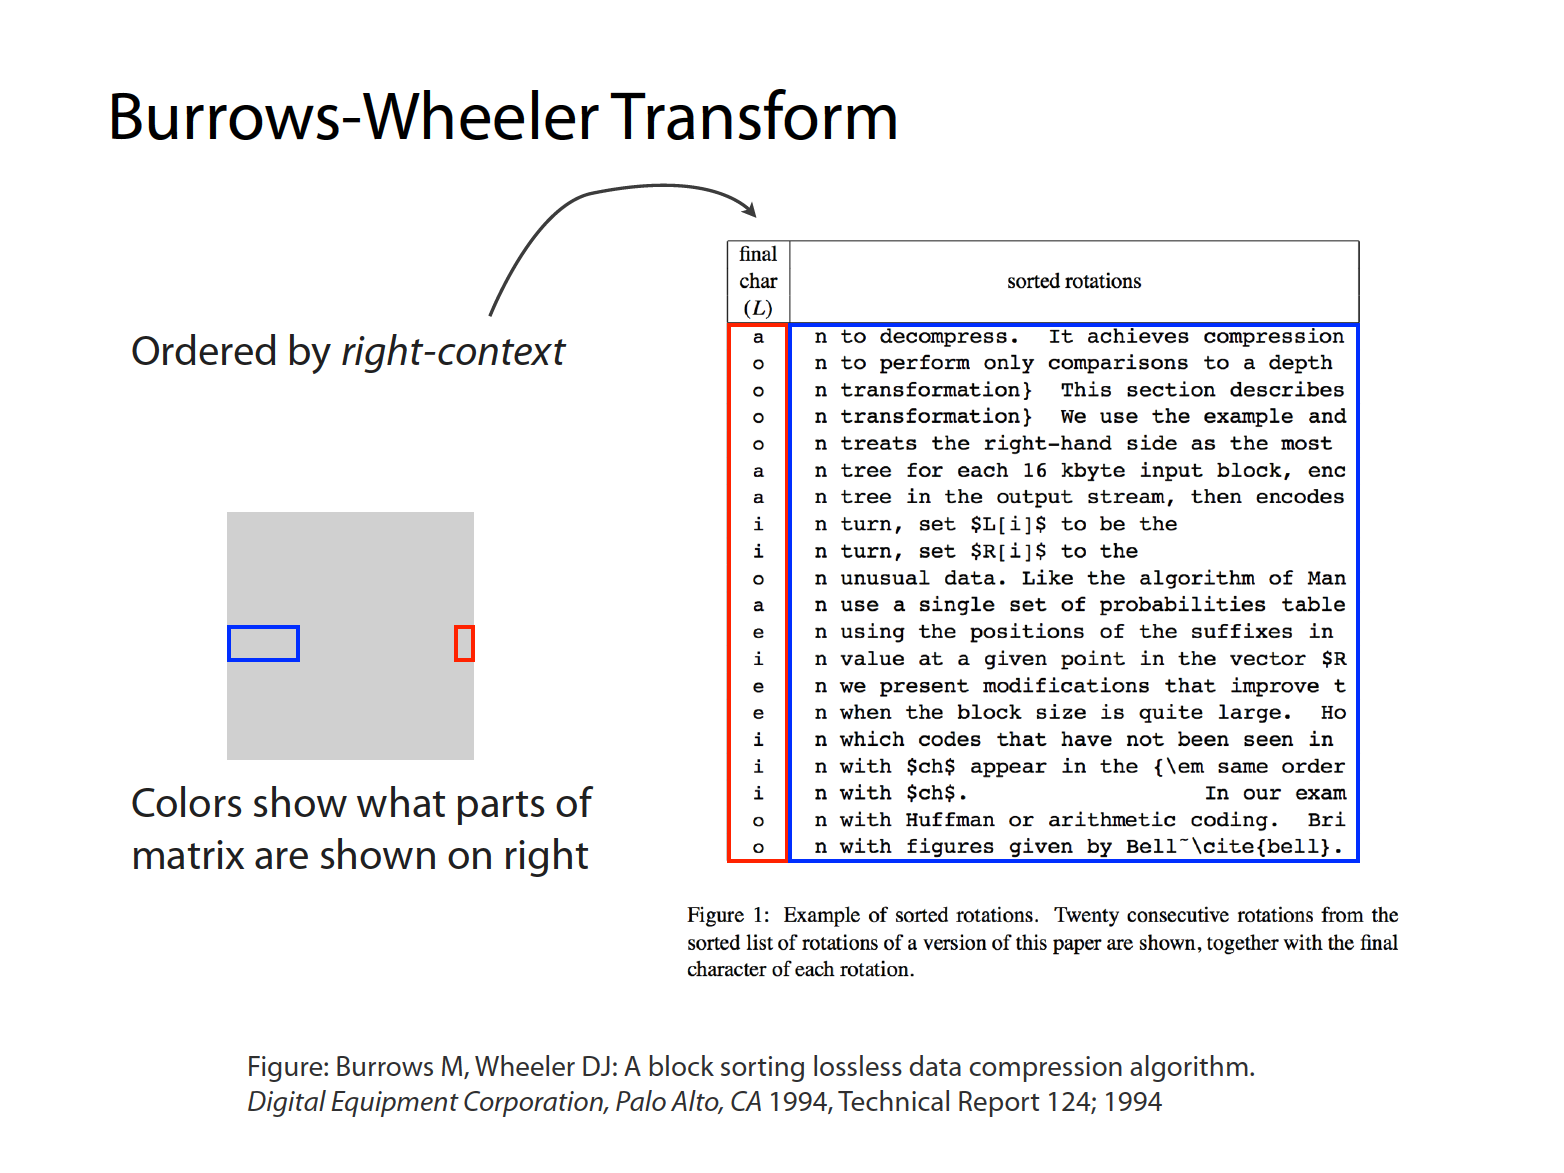

In [31]:
pretty_print_bwm('tomorrow_and_tomorrow_and_tomorrow')
#pretty_print_bwm('some_of_us_are_prisoners_the_rest_of_us_are_guards')

Burrows-Wheeler Matrix of: tomorrow_and_tomorrow_and_tomorrow

34:  $tomorrow_and_tomorrow_and_tomorro|w
21:  _and_tomorrow$tomorrow_and_tomorro|w
 8:  _and_tomorrow_and_tomorrow$tomorro|w
25:  _tomorrow$tomorrow_and_tomorrow_an|d
12:  _tomorrow_and_tomorrow$tomorrow_an|d
22:  and_tomorrow$tomorrow_and_tomorrow|_
 9:  and_tomorrow_and_tomorrow$tomorrow|_
24:  d_tomorrow$tomorrow_and_tomorrow_a|n
11:  d_tomorrow_and_tomorrow$tomorrow_a|n
28:  morrow$tomorrow_and_tomorrow_and_t|o
15:  morrow_and_tomorrow$tomorrow_and_t|o
 2:  morrow_and_tomorrow_and_tomorrow$t|o
23:  nd_tomorrow$tomorrow_and_tomorrow_|a
10:  nd_tomorrow_and_tomorrow$tomorrow_|a
27:  omorrow$tomorrow_and_tomorrow_and_|t
14:  omorrow_and_tomorrow$tomorrow_and_|t
 1:  omorrow_and_tomorrow_and_tomorrow$|t
29:  orrow$tomorrow_and_tomorrow_and_to|m
16:  orrow_and_tomorrow$tomorrow_and_to|m
 3:  orrow_and_tomorrow_and_tomorrow$to|m
32:  ow$tomorrow_and_tomorrow_and_tomor|r
19:  ow_and_tomorrow$tomorrow_and_tomor|r
 6:  ow_and_t

### Inverse BWT

In this section we will implement the reverse BWT, ie reconstruct the original text from its BWT.
If we have access to the suffix array used to generate the BWT this reversal is trivial, we just have to find the permutation that sorts the `sa` and use it to reorder `bwt`.

In [32]:
def reverseBWT(bwt, sa):
    perm = ((si, i) for i, si in enumerate(sa))  # get (element, index pairs)
    perm = (i for si, i in sorted(perm))  # sort by element get index
    text = ''.join(bwt[i] for i in perm)  
    return text[1:] # skip $

text = 'abaabac'
sa = build_suffix_array(text)
bwt = BWT(text, sa)
print(f'text: {text}')
print(f'sa  : {sa}')
print(f'bwt : {bwt}')
print(f'rbwt: {reverseBWT(bwt, sa)}')

text: abaabac
sa  : [7, 2, 0, 3, 5, 1, 4, 6]
bwt : cb$abaaa
rbwt: abaabac


We can achieve this however just with the `bwt` and 2 key observations. 
The first is again the connection between rotations and position, namely 

```
rotation[i] = text[i:] + text[:i]
```

which means that in rotation $i$ the character at position $i$ went to the front column of BWM and the character at position $i-1$ went to the last and became an element of BWT. So elements in the first column are preceded by the corresponding elements in the last column.

In [33]:
def print_color_bwm(text):
    if text[-1] != '$':
        text += '$'
    sa = build_suffix_array(text)
    tl = [f'\033[{30+i}m{t}\033[0;0m' for i, t in enumerate(text)]
    tl[-1] = f'\033[1;{30+i}m$\033[0;0m'
    print('Burrows-Wheeler Matrix of:', ''.join(tl))
    print()
    bwm = []
    for si in sa:
        bwm.append(''.join(tl[si:] + tl[:si]))
    print('\n'.join(bwm))

print_color_bwm(text)

Burrows-Wheeler Matrix of: abaabac$

$abaabac
aabac$ab
abaabac$
abac$aba
ac$abaab
baabac$a
bac$abaa
c$abaaba


Thus, knowing the First and the Last columns gives us pairs of successive characters in the text. If we find a way to "jump" from one row to the next then we will be able to reconstruct the text one character at a time.

So far we have the following ingredients:

```
F|L = BWT
$|a
a|b
a|b
a|a
a|$
b|a
b|a

text = _____a$
```

Any pair of consecutive columns has the property we want. The last column is special as we saw since it is the BWT (linked to suffix-arrays). The first column is special for 2 reasons:

1. It is the most significant column for sorting. So we know it is going to be sorted and we can just store the starting position of each character.
2. It is sorted based on the same context as the BWT so the rank (not the position) of each element is the same.

The invariance of the ranks between First and Last column means that the 0th `a` in the last column
is *the same* as the 0th `a` in the first column, in the sense that they occupy the same position in the original text. In the previous example, the order of the colors of all the `a` does not change.

Shifting an `a` from the Last to the First column cannot change its relative position with regards to the other `a`s. Its rank was determined by its right-context and if we shift everything one position to the right we will just introduce new `a` to the First column so the relative ranks will not change.

In [34]:
def print_right_context(text, a):
    bwm = list(BWM(text))
    i = 0
    F = []
    for t in bwm:
        if t[0] == a:
            i += 1
            F.append(f'\033[{30+i}m{a}\033[0;0;{40+i}m{t[1:]}\033[0;0m')
        else:
            F.append(f'\033[0;0m{t}')
    i = 0
    L = []
    for t in bwm:
        if t[-1] == a:
            i += 1
            L.append(f'\033[0;0;{40+i}m{t[:-1]}\033[0;{30+i}m{a}\033[0;0m')
        else:
            L.append(f'\033[0;0m{t}')
    
    print('F-Context   | L-Context')
    print('------------|----------')
    for f, l in zip(F, L):
        print(f' {f}   |  {l}')
    #return F, L
    
print_right_context(text, 'a')

F-Context   | L-Context
------------|----------
 $abaabac   |  $abaabac
 aabac$ab   |  aabac$ab
 abaabac$   |  abaabac$
 abac$aba   |  abac$aba
 ac$abaab   |  ac$abaab
 baabac$a   |  baabac$a
 bac$abaa   |  bac$abaa
 c$abaaba   |  c$abaaba


In [35]:
print_right_context(text, 'b')

F-Context   | L-Context
------------|----------
 $abaabac   |  $abaabac
 aabac$ab   |  aabac$ab
 abaabac$   |  abaabac$
 abac$aba   |  abac$aba
 ac$abaab   |  ac$abaab
 baabac$a   |  baabac$a
 bac$abaa   |  bac$abaa
 c$abaaba   |  c$abaaba


So if we know the *rank* of a character in BWT we can get its *position* in the First column of BWM  with the following formula:

$$\text{LF}(x_i) = F(x) + i $$

where $F(x)$ is the starting position of $x$ in the first column and can easily be computed if we know the number of *occurrences* of $x$ in BWT (4 numbers for DNA). And $i$ is the rank (order of 
appearance) of $x$.

![](figures/LF.png)

With these observation we can now implement the reverse BWT with the following steps:

1. $F(x)$: Calculate the number of `occurrences` of each character.
2. *Ranks*: calculate the `ranks` of each character in the BWT
3. *Start*: `bwt[0] == text[-1]`
4. *LF mapping*: use $\text{LF}$ to get the next position

Below we implement this strategy.


In [36]:
def LFmapping(bwt):
    """ 
    Given a BWT it create an LF mapping function.
    The function takes as input the character and its position it BWT and returns the position of the next character.
    It is a Factory Function (a function that returns functions).
    See: https://en.wikipedia.org/wiki/Factory_(object-oriented_programming)
    """
    # Count Occurances and Rank characters
    occs = {}  # counter for each character
    ranks = []
    for c in bwt:
        if c not in occs:
            occs[c] = 0  # fist occurance
        ranks.append(occs[c])
        occs[c] += 1
    
    # occurances to F(x) == cummulative function
    first = {}
    idx = 0
    for c, count in sorted(occs.items()): 
        first[c] = idx
        idx += count
    
    # define LF function
    def LF(x, i):
        # This function remember the first and ranks from its local environment
        #          F(x) + i
        return first[x] + ranks[i]
    
    return LF

def reverseBWT(bwt, sa=None):
    """ Make T from BWT(T) """
    if sa is not None:
        # previous case, we just need to sort sa
        perm = np.argsort(sa)
        return ''.join(bwt[i] for i in perm[1:])
    LF = LFmapping(bwt)
    i = 0   # start in first row
    t = '$' # $ is always in row 0
    # build the string from right to left
    while bwt[i] != '$':
        c = bwt[i]
        t += c 
        i = LF(c, i) # jump to row that starts with c of same rank
    return t[::-1][:-1]   # reverse to get original string & skip $

In [37]:
text = 'abaabac'
bwt = BWT(text)
print(f'text: {text}')
print(f' bwt: {bwt}')
print(f'rbwt: {reverseBWT(bwt)}')

text: abaabac
 bwt: cb$abaaa
rbwt: abaabac


### FM index

> Original paper: [Opportunistic data structures with applications](https://doi.org/10.1109/SFCS.2000.892127)

We are almost ready to map reads using BWT. Our general strategy would be to progressively map the suffix of the read. Since BWT is essentially equivalent to a suffix array this will generate a range of possible suffix positions. The benefit compared to `SAIndex` is that we do not have to compare the whole suffix at every step (`self.text[i:i+len(p)] < p`). We only have to process 1 character at a time and by the time we reach the last character we will know if and where this suffix occurs in the text. So the time it takes us to read the sequence is proportional (with a ratio not much bigger than 1) to the time it takes us to map it!

There are 2 main steps involved in shrinking a range $[l, h]$:

1. Vertical Step: given a character find the tightest range including all its appearances in
   $l,h \to l_x,h_x$ 
2. Zig-zag step: apply the LF function at the positions $l_x, h_x$

The vertical steps recovers all the suffices $S$ that can be extended by $x$ (to $xS$)
and all the other in-between. The zigzag/LF step maps the $l_x, h_x$ to the first column which we know is sorted and thus the resulting range consists only of suffixes of the form $xS$, and the rest are discarded.

![](figures/FMindex.png)

Some details before we implement this strategy. First, these steps give us a range in the BWT "coordinates" but what we care about is where in the text/genome the pattern/read occurs. We could get that by reversing the BWT but that would be wildly inefficient so instead we keep a copy of the suffix array used to generate the `bwt` which has the coordinates of the original genome (so I lied initially when I suggested we do not need it). Second, if the read does not occur anywhere in the genome then the resulting range will be of 0 length or negative.

In [38]:
class FMIndex:
    @staticmethod
    def BWT(T):
        # sa = sort i by the suffix it defines
        sa = sorted(range(len(T)), key = lambda i: T[i:])  
        bwt = ''.join(T[i - 1] for i in sa)
        return bwt, sa
    
    def __init__(self, T):
        if T[-1] != '$':
            T += '$'
        self.bwt, self.sa = self.BWT(T)
        self.LF = LFmapping(self.bwt)
        
    def _match(self, p):
        low = 0
        high = len(self.bwt)-1
        for c in reversed(p):
            # step up
            low += self.bwt[low:].find(c)  # find from left
            low = self.LF(c, low) 
            # step down
            high = self.bwt[:high+1].rfind(c)  # find from right
            high = self.LF(c, high)  # zig-zag
            if low > high:
                break
        return low, high + 1
    
    def __contains__(self, p):
        low, high = self._match(p)
        return low < high
    
    def __getitem__(self, p):
        low, high = self._match(p)
        if low > high:
            return []
        return self.sa[low:high]

text = 'abaabac'
print(''.join(map(str, range(len(text)))))
print(text)
print()
FMI = FMIndex(text)
FMI['ab']

0123456
abaabac



[0, 3]

The implementation of `FMIndex` given aims to maximize simplicity and readability (under the constraint that it is correct). For practical purposes however some trade-offs are made to decrease execution time and space requirements.

First, the "vertical step" (`.find(c)`) is clearly the bottleneck in terms of speed since it has to traverse the BWT checking every character and we know that BWT tends to group the same characters together so we expect these scans to be very long. To combat that, we can pre-calculate the "effective" rank of every character for every position. The rank a character is incremented every time it appears in BWT, in-between these appearances the "effective-rank" is the current highest rank so essentially it is the cumulative function of the rank-vector of each character

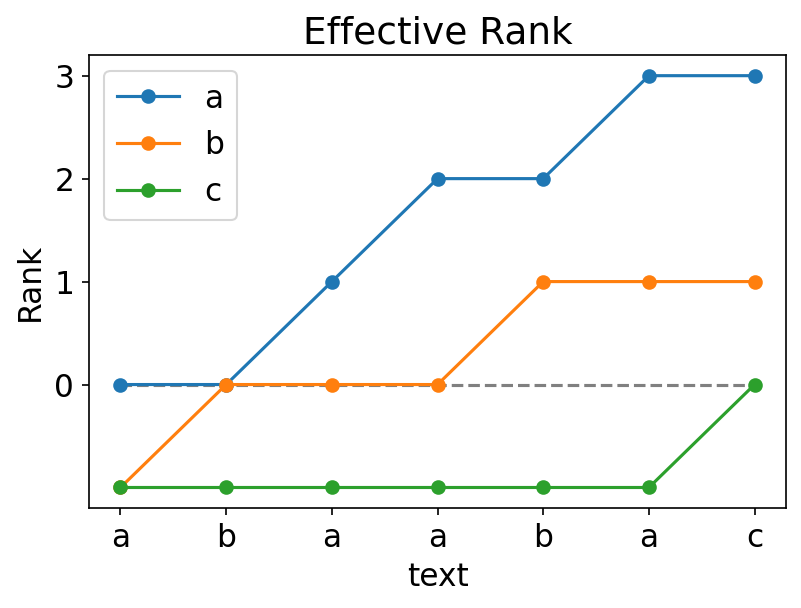

In [36]:
def rank_cdf(text):
    N = len(text)
    occ = {}
    for i, c in enumerate(text):
        if c not in occ:
            occ[c] = np.zeros(N)
        occ[c][i] = 1
    
    x = np.arange(N)
    Rm = 0
    plt.plot([0, N-1], [0, 0], '--', color = 'gray')
    for c in occ:
        y = np.cumsum(occ[c]) - 1
        plt.plot(x, y, '-o', label = c)
        if y[-1] > Rm:
            Rm = y[-1]

    plt.ylabel('Rank')
    plt.xlabel('text')
    plt.xticks(x, list(text))
    plt.yticks(np.arange(Rm + 1))
    plt.title('Effective Rank')
    plt.legend()
    plt.show()
    
text = 'abaabac'
rank_cdf(text)

Below we implement such an index by defining a class `LFCheckpoints` to store all the effective
ranks and do thus implement the $\text{LF}$ step very fast.

In [37]:
class LFCheckpoints:
    
    @staticmethod
    def effective_ranks(bwt):
        """Creates a dict of effective rank for each character in bwt character counts.
        The checkpoint are indexed by character and they have a list of counts for every checkpoint.
        The last element of the list is the total number of counts
        """
        ckps = {}
        N = len(bwt)
        for i, c in enumerate(bwt):
            if c not in ckps:
                ckps[c] = [0] * N
            ckps[c][i] = 1
        for c, occ in ckps.items():
            for i in range(1, N):
                occ[i] += occ[i-1]  # cumsum
            ckps[c] = occ
        return ckps
    
    @staticmethod
    def ranks2rle(ranks):
        """Computes a running-length encoding representation of First column"""
        first, row = {}, 0
        for c, ckp in sorted(ranks.items()):
            first[c] = row
            row += ckp[-1]  # add total tally
        return first
    
    def __init__(self, bwt):
        self.N = len(bwt)
        self.rank = self.effective_ranks(bwt)
        self.first = self.ranks2rle(self.rank)
    
    def __call__(self, c, i):
        if i < 0:
            return self.first[c]
        i = min(i, self.N - 1)
        return self.first[c] + self.rank[c][i]

class FMIndex:
    @staticmethod
    def BWT(T):
        # sa = sort i by the suffix it defines
        sa = sorted(range(len(T)), key = lambda i: T[i:])  
        bwt = ''.join(T[i - 1] for i in sa)
        return bwt, sa
    
    def __init__(self, T):
        if T[-1] != '$':
            T += '$'
        self.bwt, self.sa = self.BWT(T)
        self.LF = LFCheckpoints(self.bwt)
    
    def _match(self, p):
        low, high = 0, len(self.bwt)
        for c in reversed(p):
            low  = self.LF(c, low - 1)  # counts up to but not including low (so 1st low has index 0)
            high = self.LF(c, high) - 1 # counts up to high. -1 to turn it into index
            if low > high:
                break
        return low, high + 1  # +1 to work with slise notation
        
    def __contains__(self, p):
        low, high = self._match(p)
        return low < high
    
    def __getitem__(self, p):
        low, high = self._match(p)
        if low > high:
            return []
        return [self.sa[i] for i in range(low, high)]

In [38]:
p, t = "CAT", "TTGTGTGCATGTTGTTTCATCATTTAGAGATACATTGCGCTGCATCATGGTAG"
#              01234567890123456789012345678901234567890123456789012
# Occurrences:        *         *  *           *         *  *
FMI = FMIndex(t)
matches = sorted(FMI[p])
assert matches == [7, 17, 20, 32, 42, 45]

The problem with the above implementation is that it uses too much space!

To measure the space efficiency of our approach we will use as base value the memory footprint of
the genome ($6 \cdot 10^9 bp \times 2 \frac{\text{bits}}{bp} \approx 1.5 \text{Gb}$ ). For the 
`first` column we have to store 4 integers so practically nothing. The `bwt` is the genome just 
re-ordered so 1Genome must be used for that. We also stored the `sa` which is also as large as the 
genome. And finally we have to add the effective ranks which are 4 Genomes worth of space (if we 
are clever about `$`). So overall we need 6 genomes worth of space ie 9Gb which is not terrible 
since a hash table using of k-mers needs $k$ genomes worth and $k \gt 6$ for all practical 
purposes. However, `sa` and `rank` cannot be stored using 2 bits since we need them to store large 
integers ($\log_2 6 \cdot 10^9 \approx 36$ bits).

We can balance the scale less in favor of speed. Bowtie uses *checkpoints*, ie it stores every `N` positions and in between it executes the slow scans to compute the ranking or LF steps for the  SA. By tuning the number of checkpoint we can trade-off speed for memory.

Below is an implementation for such a code

In [42]:
class LFCheckpoints:
    
    @staticmethod
    def _make_checkpoints(bwt, period):
        """Creates a dict of periodic checkpoints for bwt character counts.
        The checkpoint are indexed by character and they have a list of counts for every checkpoint.
        The last element of the list is the total number of counts
        """
        ckps = {}
        N = len(bwt) // period + 1 # + 1 to store the total count
        I = 0
        for i, c in enumerate(bwt):
            if c not in ckps:
                ckps[c] = [0] * N
            ckps[c][I] += 1
            if (i + 1) % period == 0:
                I += 1
                for C in ckps:
                    ckps[C][I] = ckps[C][I-1]
        return ckps
    
    @staticmethod
    def _ckps2rle(ckps):
        """Computes a running-length encoding representation of First column"""
        first, row = {}, 0
        for c, ckp in sorted(ckps.items()):
            first[c] = row
            row += ckp[-1]  # add total tally
        return first
    
    def __init__(self, bwt, period=4):
        self.bwt = bwt
        self.period = period
        self.ckps = self._make_checkpoints(self.bwt, self.period)
        self.first = self._ckps2rle(self.ckps)
    
    def count(self, c, i):
        """Counts the occurances of 'c' in self.bwt up to and including position i.
        Fast alternative to bwt[:i+1].count(c)"""
        if i < 0:
            return 0
        if i >= len(self.bwt):
            return self.ckps[c][-1]
        J = i // self.period  # previous checkpoint
        rank = self.ckps[c][J-1] if J > 0 else 0
        j = J * self.period
        rank += self.bwt[j : i+1].count(c)
        return rank
    
    def __call__(self, c, i):
        return self.first[c] + self.count(c, i)

class FMIndex:
    @staticmethod
    def BWT(T):
        # sa = sort i by the suffix it defines
        sa = sorted(range(len(T)), key = lambda i: T[i:])  
        bwt = ''.join(T[i - 1] for i in sa)
        return bwt, sa
    
    @staticmethod
    def _downsampleSA(sa, n):
        """ Take only the suffix-array entries for every nth suffix.  Keep
            suffixes at offsets 0, n, 2n, etc with respect to the text.
            Return map from the rows to their suffix-array values. """
        ssa = {}
        for i, suf in enumerate(sa):
            # We check suf % n == 0 because LF maps between sa[i] so when we have to resolve
            # we will not walk along i but suf.
            if suf % n == 0:
                ssa[i] = suf
        return ssa
    
    def __init__(self, T, p_rank=4, p_sa = 4):
        if T[-1] != '$':
            T += '$'
        self.bwt, sa = self.BWT(T)
        self.ssa = self._downsampleSA(sa, p_sa)
        self.LF = LFCheckpoints(self.bwt, p_rank)
    
    def _match(self, p):
        low, high = 0, len(self.bwt)
        for c in reversed(p):
            low  = self.LF(c, low - 1)  # counts up to but not including low (so 1st low has index 0)
            high = self.LF(c, high) - 1 # counts up to high. -1 to turn it into index
            if low > high:
                break
        return low, high + 1  # +1 to work with slise notation
    
    def _resolve(self, row):
        """ Given BWM row, return its offset w/r/t T """
        nsteps = 0
        while row not in self.ssa:
            row = self.LF(self.bwt[row], row - 1)
            nsteps += 1
        return self.ssa[row] + nsteps
        
    def __contains__(self, p):
        low, high = self._match(p)
        return low < high
    
    def __getitem__(self, p):
        low, high = self._match(p)
        if low > high:
            return []
        return [self._resolve(i) for i in range(low, high)]

In [43]:
p, t = "CAT", "TTGTGTGCATGTTGTTTCATCATTTAGAGATACATTGCGCTGCATCATGGTAG"
#              01234567890123456789012345678901234567890123456789012
# Occurrences:        *         *  *           *         *  *
FMI = FMIndex(t, 4, 4)
matches = sorted(FMI[p])
assert matches == [7, 17, 20, 32, 42, 45]

### Example: BWA

> Paper: https://doi.org/10.1093/bioinformatics/btp324

Essentially, this algorithm uses backward search to sample distinct substrings from the genome. This process is bounded by the `D` array where `D[i]` is the lower bound of the number of differences in $W[0, i]$. The better the `D` is estimated, the smaller the search space and the more efficient the algorithm is. A naive bound is achieved by setting `D[i]=0` for all `i`, but the resulting algorithm is clearly exponential in the number of differences and would be less efficient. 

In [44]:
class BWA:
    def __init__(self, reference, cpIval=4, ssaIval=4, mis_penalty=1, ins_penalty=1, del_penalty=1):
        self.FMf = FMIndex(reference,       cpIval, ssaIval)
        self.FMr = FMIndex(reference[::-1], cpIval, ssaIval)
        self.N = len(self.FMf.bwt)
        self.alphabet = list(self.FMf.LF.first.keys())
        self.alphabet.remove('$')
        #self.penalty = {'miss': mis_penalty, 'ins': ins_penalty, 'del': del_penalty}
    
    def _step(self, FM, low, high, c):
        low = FM.LF(c, low-1)
        high = FM.LF(c, high) - 1
        return low, high
    
    def _step_fwd(self, l, h, c):
        return self._step(self.FMf, l, h, c)
    
    def _step_bak(self, l, h, c):
        return self._step(self.FMr, l, h, c)
    
    def _exact_search(self, pattern):
        return self.FMf[pattern]
    
    def _inexact_search(self, pattern, z):
        l, r = 0, self.N
        D = self.calculate_D(pattern)
        ranges = self._inexact_recursion(pattern, D, len(pattern)-1, z, l, r)
        matches = []
        for l, r in ranges:
            for i in range(l, r):
                matches.append(self.FMf._resolve(i))
        return matches
        
    def _inexact_recursion(self, pattern, D, i, z, l, r):
        # Base Cases
        if z < D[i]:
            return set()
        if i < 0:
            return set([(l, r+1)])
        
        # Recursion
        I = set()
        #I.update(self._inexact_recursion(pattern, D, i-1, z-1, l, r))
        for c in self.alphabet:
            lc, rc = self._step_fwd(l, r, c)  # suggested jump, need to keep old l, r
            if lc <= rc:
                #I.update(self._inexact_recursion(pattern, D, i, z-1, lc, rc))
                if c == pattern[i]:
                    # no penalty to move to i-1
                    I.update(self._inexact_recursion(pattern, D, i-1,  z , lc, rc))
                else:
                    # we pay penalty z - 1 to move to i-1
                    I.update(self._inexact_recursion(pattern, D, i-1, z-1, lc, rc))
        return I

    def calculate_D(self, pattern):
        l, r = 0, self.N
        z = 0  # number of misses
        D = [0] * len(pattern)
        for i, c in enumerate(pattern):
            l, r = self._step_bak(l, r, c)
            if l > r:
                # no substring p[N-i]
                z += 1  # found mismatch
                l, r = 0, N  # restart
            D[i] = z
        return D
    
    def find_matches(self, pattern, mismatches=0):
        assert mismatches >= 0
        if mismatches == 0:
            return self._exact_search(pattern)
        return self._inexact_search(pattern, mismatches)

In [45]:
p, t = "CAT", "TTGTGTGCATGTTGTTTCATCATTTAGAGATACATTGCGCTGCATCATGGTAG"
#              01234567890123456789012345678901234567890123456789012
# Occurrences:        *         *  *       ^   *         *  *
Aligner = BWA(t)
matches = sorted(Aligner.find_matches(p, mismatches=0))
tick = '✅' if matches == [7, 17, 20, 32, 42, 45] else '❌'
print(f'Exact Matches: {matches} {tick}')
matches = sorted(Aligner.find_matches(p, mismatches=1))
tick = '✅' if matches == [7, 17, 20, 28, 32, 42, 45] else '❌'
print(f'1-miss Matches: {matches} {tick}')

Exact Matches: [7, 17, 20, 32, 42, 45] ✅
1-miss Matches: [7, 17, 20, 28, 32, 42, 45] ✅


In [46]:
p, t = "gta", "atgcgtaatgccgtcgatcg"
#              01234567890123456789
#                  *       ^
Aligner = BWA(t)
z = 1
matches = sorted(Aligner.find_matches(p, z))
assert matches == [4, 12]

In [47]:
p, t = "LOL", "GOOGOL"
Aligner = BWA(t)
z = 1
matches = sorted(Aligner.find_matches(p, z))
assert matches == []

### MEM seeds

Popularized in the context of read alignment by [BWT-MEM](https://arxiv.org/abs/1303.3997)

> A Maximal Exact Match (MEM) is a subsequence of the read that is present in the reference genome (*exact*) and that cannot be extended further (*maximal*), either because the read ends or because the extended subsequence is not in the genome.

They are an example of variable-sized seeds and are calculated via the FM index. In this case, $k$ acts as a lower bound so all MEMs smaller than $k$ are ignored. They dramatically reduce redundancy in our seeds so they increase specificity.

The main motivation for finding MEMs, comes from aligning long reads or even genomes. Because of their defining properties they are very likely to be part of an optimal pairwise alignment. 
[BWA-MEM] for example uses MEMs as seeds in a BLAST-like approach which includes *chaining* of co-linear MEMs, *X-drop* and *SW* local alignment.

MEMs are vulnerable to certain error distributions. In particular, uniform distribution tend to lead to smaller MEMs while congregated errors lead to longer ones. This can lead to the following counter-intuitive results:

1. Multiple errors congregating in a small region can produce longer MEMs than few errors strategically placed. 


![no MEM for target](https://www.frontiersin.org/files/Articles/519351/fgene-11-00572-HTML-r2/image_m/fgene-11-00572-g004.jpg)

2. Multiple errors congregating in a small region close to the edge of the read may make it preferable to trim the read.

![shorter reads yield better results](https://www.frontiersin.org/files/Articles/519351/fgene-11-00572-HTML-r2/image_m/fgene-11-00572-g005.jpg)

## MApping Quality (MAPQ) score

Last time we learn how to calculate the alignment score `AS` (as the edit distance or similarity).
This score quantifies the quality of **pairwise** alignment and we sketched the theory used by BLAST to construct a null distribution for this score. The **mapping** score does not refer to a single pairwise alignment but all the possible alignment of given read to a reference genome.
We want a score that quantifies how certain we are about the genomic interval that the read is mapped to.

$$ Q_M = -10 \log_{10} P(\text{mapping is incorrect})$$


So we have an aligner that acts as a map function $M$ that takes as input a read sequence $r$ and reference sequence $G$ and returns an alignment which consists of a set genomic interval 
$G_u^l = [u, u+l)$ and their corresponding match/mismatch patterns $C$. And we want to use these information to calculate the score for the **best alignment** (we usually but not always ignore the rest unless anyway). Every aligner has its own inner working ([for example](http://www.acgt.me/blog/2014/12/16/understanding-mapq-scores-in-sam-files-does-37-42)) and thus computes its own `MAPQ` score (eg [bowtie2](https://biofinysics.blogspot.com/2014/05/how-does-bowtie2-assign-mapq-scores.html)) which are not comparable between them (perhaps not even between versions of the same aligner) so there is no unifying theory for how to do this. The "general theory" is that we want to estimate the following null distribution:

$$P_M(u \mid G, r) = \frac{p(r|G_u^l) p(u)}{\sum_u p(r|G_u^l)}$$

Which then we are going to use to estimate the probability of error:

$$\epsilon_M = 1 - \max_u P_M(u \mid G, r)$$

where $\hat{u}, \hat{l} = \underset{u, l}{\operatorname{argmax}} P_M(u \mid G, r)$ is the best alignment reported by the aligner. $u \in \{1, 2, \dots, L-l-1\}$ is the start position and we use $u=0$ to denote that the read does not come from the reference.

[MAQ](http://www.genome.org/cgi/doi/10.1101/gr.078212.108) (see supplementary and also [manual](http://maq.sourceforge.net/qual.shtml)) was one of the first aligner to define MAPQ in a "principled" way so we will use this to get a sense of what considerations go into estimating this score. The analysis is for single-end reads (SE) so for paired-end it is even more complicated. 

MAQ decomposes the error term as the sum of 3 contributing factors:

1. $\epsilon_{M_1} = p(u=0 \mid \hat{u} \gt 0)$ 
   the probability that the read does not come from $G$
2. $\epsilon_{M_2} = p(u \not\in \Omega \mid \hat{u} \gt 0, U > 0)$ 
   the probability that the true region was missed by the aligner.
3. $\epsilon_{M_3} = p(\hat{u} \neq u \mid \hat{u} \gt 0, U > 0, u \in \Omega)$
   the probability that the best alignment is correct.

where $\Omega$ is the set of intervals considered by the aligner.

Since all these factors should be small the error can be approximated by their max as well:

$$
\epsilon_M = 
    \epsilon_{M_1} + \epsilon_{M_2} + \epsilon_{M_3} \approx 
    \max(\epsilon_{M_1}, \epsilon_{M_2}, \epsilon_{M_3})
$$


The $\epsilon_{M_1}$ is mainly cause by contamination or using the wrong reference. If the probability of these errors is much greater than 0 then alignment errors is the least of our problems. Thus this term is ignored by MAPQ.

The $\epsilon_{M_2}$ refers to the scenario where the true read is corrupted by error in a way that makes another interval rise as the best. Assuming that the true read has $k$ mismatches and the best has $\hat{k} \le k$ this probability is affected by:

- The difference of their quality $\Delta k = k - \hat{k}$
- The heuristics of the algorithm for $k$

All aligners employ various heuristics and cutoffs to shrink the search space before even attempting to align the reads. A common heuristic is to ignore alignment with more than a certain number of mismatches. If $k \gt k_{\text{cutoff}}$ then the true alignment will not even be considered. Typical cutoff values are 2 or 3, especially at the beginning of short reads (first 28bp).

The difference of the alignment scores $\Delta k$ affects the probability of observing a interval with better alignment than the true one. For this to happen there need to be:

- $\Delta k$ additional mismatches in the read coming from the true region. 
  MAQ assumes that these mismatches arise randomly with fixed probability so it models it as:
  $\text{Binom}(l-\hat{k}, p_e)$, $p_e$ is the base calling error (FASTQ values can be used as well).
- Enough region of the genome that can give rise to such alignments. These depends on the repeat structure of the genome and the read.

The $\epsilon_{M_3}$ is affected by the quality of the best alignment. If the best alignment dominates the sum $\sum_u P(r \mid G, u) P(u)$ then this error is low otherwise by ignoring the rest we are "discarding" a lot of probability. The sum is affected both by the score of alignment and how many alignments have each score. If, for example, there are many perfect alignments (because the read came from a repeat region) then we do not have confidence that any of them is a good mapping.


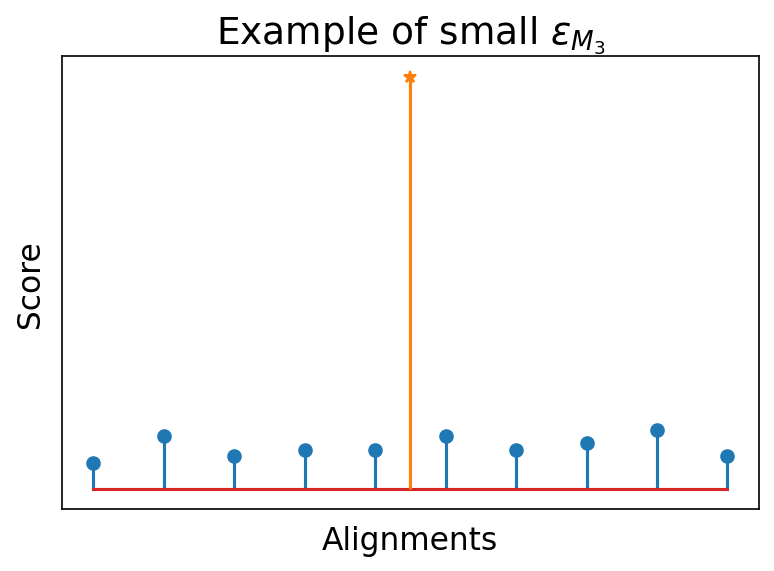

In [48]:
L = 64
x = rng.binomial(L, p=0.1, size=10)
plt.stem(np.arange(10), x)
plt.stem([4.5], L-1, linefmt='C1-', markerfmt='C1*')
plt.xticks([])
plt.xlabel('Alignments')
plt.ylabel('Score')
plt.yticks([])
plt.title('Example of small $\epsilon_{M_3}$')
plt.show()

## Further Reading

- [Another Review](https://www.doi.org/10.1146/annurev-genom-090413-025358)
- [Compressed full-text indexes](https://dl.acm.org/doi/10.1145/1216370.1216372)
- [Benchmarking short sequence mapping tools ](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-14-184)


## Appendix

### Long Read Mapping

So far we have been implicitly dealing with short-read mapping. Although the theory we describe does not depend on the length of pattern/read, the trade-offs and the heuristics used for alignment are very much based on assumptions specific to short-reads. 


For long (> 1kbp) reads some of these assumptions do not hold anymore like:

- **error rates**: longer reads have higher error rates ($\sim 10\%$ vs $0.1\%$)
- **error types**: longer reads are affected by indels while shorter reads mostly substitutions

These error profiles necessitate the use of a Smith-Waterman type alignment since we cannot bound
the possible errors a-priori and perform a simple backtrack.

Thus long-read aligners tend to combine ideas of BWT with hash table approaches. 
The standard approach, used for example by [BWA-MEM](https://arxiv.org/abs/1303.3997), 
is to first find a set of MEMs (or some of their derivatives) and use them as seeds to 
be linked via SW alignment (similar to how BLAST works but with variable length seeds). 
There are also derivative algorithms of SW, that implement heuristics and/or hardware
tricks to accelerate the process. Nowadays (ie 2022), [minimap2](https://github.com/lh3/minimap2) 
is now the dominant alinger for long reads.

### Polymorphic Reference

As we know there is no *single* human (or any other's species for that matter) genome. 
Genetic variability is around 1/1000 for single-nucleotide-polymorphisms, so we expect 
reads to systematic mismatches when compared to the reference.

To address this bias and to make the alignment more robust, we can incorporate information
to our reference. There are several ways to do that, in order of "coolness" (least to most)
some of them are:

1. "Mask" the genome at the polymorphic position (use `N`) so that aligners skip them
2. [Use multiple genomes](https://doi.org/10.1101/2020.03.03.975219 ) 
   (eg [1000 Genome project](https://www.internationalgenome.org/))
   and do 2 passes over the reads (the second dealing with those that have errors)
3. [Wheeler graphs](http://dx.doi.org/10.1016/j.tcs.2017.06.016) which are essential 
   the BWT version of de-Bruijn graphs.

### Alignment Reconstruction

Unlike the case of pairwise alignment, the typical output of a read mapping aligner (sam file)
does not contain a clear representation of the alignment (we never see reads matched against 
reference). We can however reconstruct the alignment of every read using the `SEQ`, `CIGAR`,
and `MD:Z` tags of the sam file. See for example [here](https://github.com/mlafave/sam2pairwise).

`SEQ` and `CIGAR` can almost get us there, the problem is what is the reference sequence
when we have a deletion (`D`) or mismatch (`X`). In these cases the `MD:Z` tag has the necessary
information to fill in the gaps. 

See documentation for how the 2 fields are defined:

- [CIGAR](https://samtools.github.io/hts-specs/SAMv1.pdf)
- [MD:Z](https://samtools.github.io/hts-specs/SAMtags.pdf)

Below we implement such a function:

In [44]:
import re


def parse_cigar(cigar):
    # Check it is a valid CIGAR string
    # pattern = digits + one of 'M=XIDNSHP' repeated 1 or more times
    cigar_pattern = re.compile(r'^([0-9]+[MIDNSHPX=])+$')
    if cigar_pattern.match(cigar) is None:
        raise ValueError(f'Invalid CIGAR string: {cigar}')
    # Main: Loop over all runs (digit characters)
    for m in re.finditer(r'[0-9]+', cigar):
        # m.group() == cigar[m.start():m.end()]
        run = int(m.group())
        op = cigar[m.end()]
        yield (op, run)

def parse_mdtag(md):
    # check that is a valid MD:Z
    md_pattern = re.compile(r'^[0-9]+(([A-Z]|\^[A-Z]+)[0-9]+)*$')
    if md_pattern.match(md) is None:
        raise ValueError(f'Invalid MD tag: {md}')
    
    # Get 1st run (always starts with run)
    match_iter = re.finditer(r'[0-9]+', md)
    m = next(match_iter)
    yield ('=', int(m.group()), '')
    i = m.end()
    for m in match_iter:
        j, run = m.start(), m.group()
        # first add previous mismatch/deletion
        mis = md[i:j]
        if mis.startswith('^'):
            mis = mis[1:]
            yield ('D', len(mis), mis)
        else:
            yield ('X', len(mis), mis)
        # then add current run
        yield ('=', int(run), '')
        i = m.end()  # start of next mis/del

def reconstruct_alignment(seq, CIGAR, MD):
    query, sbjct = '', ''  # read and ref sequence to print
    i = 0  # index of seq
    MD = iter(parse_mdtag(MD))
    md_op, md_run, md_seq = next(MD)
    for op, run in parse_cigar(CIGAR):
        if op in 'M=X':
            query += seq[i:i+run]
            # Build subject (either match or mis)
            while run > 0:
                common = min(run, md_run)
                # if match read seq, if not read from MD
                if md_op == '=':
                    sbjct += seq[i:i+common]
                elif md_op == 'X':
                    sbjct += md_seq
                else:
                    raise RuntimeError('CIGAR and MD:Z are incompatible')
                # Prepare for next run
                i += common
                run -= common
                md_run -= common
                if md_run == 0:
                    try:
                        md_op, md_run, md_seq = next(MD)
                    except StopIteration:
                        # if MD is exchausted so must be the CIGAR run
                        assert run == 0
                elif md_run < 0:
                    raise RuntimeError('CIGAR and MD:Z are incompatible')
        elif op == 'I':
            # Insertion: seq has extra chracters
            sbjct += '-' * run
            query += seq[i:i+run]
            i += run
        elif op == 'D':
            # Deletion: seq has missing characters
            assert md_op == op and md_run == run
            sbjct += md_seq
            query += '-' * run
            md_op, md_run, md_seq = next(MD)  # no need to "try" it cannot end in deletion
        elif op == 'N':
            # skipped region from the reference (eg introns)
            sbjct += '-' * run
            query += '-' * run
        elif op == 'S':
            # Soft clipping: clipped sequences present in seq
            sbjct += ' ' * run
            query += seq[i:i+run].lower()
            i += run
        elif op == 'H':
            # Hard clipping: clipped sequences NOT present in seq
            sbjct += ' ' * run
            query += '!' * run
        elif op == 'P':
            # Padding: silent deletion from padded reference
            # used for aesthetic reasons in multiple alignments (probably)
            raise RuntimeError('Cannot handle P in CIGAR')
        else:
            # should never run if parse_cigar is correct
            raise RuntimeError(f'Uknown CIGAR operation: {op}')
        
    return sbjct, query


# Examples from Langmead
assert list(parse_cigar('10=1X10=')) == [('=', 10), ('X', 1), ('=', 10)]
assert list(parse_mdtag('10A5^AC6')) == [('=', 10, ''), ('X', 1, 'A'), ('=', 5, ''), ('D', 2, 'AC'), ('=', 6, '')]
assert reconstruct_alignment('GGACGCTCAGTAGTGACGATAGCTGAAAACCCTGTACGATAAACC', '12M2D17M2I14M', '12^AT30G0') == ('GGACGCTCAGTAATGTGACGATAGCTGAAAA--CTGTACGATAAACG', 'GGACGCTCAGTA--GTGACGATAGCTGAAAACCCTGTACGATAAACC') 
assert reconstruct_alignment('GGACGCTCAGTAGTGACGATAGCTGAAAACCCTGTACGAGAAGCC', '12M2D17M2I8M6S', '12^AT25') == ('GGACGCTCAGTAATGTGACGATAGCTGAAAA--CTGTACGA      ', 'GGACGCTCAGTA--GTGACGATAGCTGAAAACCCTGTACGAgaagcc')
assert reconstruct_alignment('GGACGCTCAGTAGTGACGATAGCTGAAAACCCTGTACGAGAAGCC', '12M2D17M2I8M6S3H', '12^AT25') == ('GGACGCTCAGTAATGTGACGATAGCTGAAAA--CTGTACGA         ', 'GGACGCTCAGTA--GTGACGATAGCTGAAAACCCTGTACGAgaagcc!!!')
assert reconstruct_alignment('GGACGCTCAGTAGTGACGATAGCTGAAAACCCTGTACGAGAAGCC', '12M2D10M10N7M2I8M6S3H', '12^AT25') == ('GGACGCTCAGTAATGTGACGATAG----------CTGAAAA--CTGTACGA         ', 'GGACGCTCAGTA--GTGACGATAG----------CTGAAAACCCTGTACGAgaagcc!!!')